<a href="https://colab.research.google.com/github/matbar97/Software-to-support-analysis-and-classification-of-lesions-on-X-ray-lung-images/blob/main/224_VGG19_X_ray_dataset_250_per_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the workspace

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi

Thu Sep 30 13:02:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


# Lib loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, hinge_loss
from scipy import interp
from itertools import cycle

# Set-up for X-ray data I (to get labels for SVM training)

In [ ]:
categories = ['bacterial_pneumonia', 'covid-19','normal','tuberculosis', 'viral_pneumonia']
data_dir = 'X-ray dataset 250 per class/train'
train_dir = 'X-ray dataset 250 per class/train'
train_dir = os.path.join(train_dir)
val_dir ='X-ray dataset 250 per class/val'
val_dir = os.path.join(val_dir)
test_dir ='X-ray dataset 250 per class/test'
test_dir =os.path.join(test_dir)

print(categories)

['bacterial_pneumonia', 'covid-19', 'normal', 'tuberculosis', 'viral_pneumonia']


In [ ]:
train_data = []
val_data = []
test_data=[]
for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(train.head())

for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(val_dir, sp)):
            val_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

val = pd.DataFrame(val_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(val.head())


for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(test_dir, sp)):
            test_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

test = pd.DataFrame(test_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(test.head())


                               File  DiseaseID         Disease Type
0    bacterial_pneumonia/0 (2).jpeg          0  bacterial_pneumonia
1  bacterial_pneumonia/125 (2).jpeg          0  bacterial_pneumonia
2  bacterial_pneumonia/126 (2).jpeg          0  bacterial_pneumonia
3  bacterial_pneumonia/116 (2).jpeg          0  bacterial_pneumonia
4  bacterial_pneumonia/121 (2).jpeg          0  bacterial_pneumonia
                                              File  ...         Disease Type
0  bacterial_pneumonia/person139_bacteria_663.jpeg  ...  bacterial_pneumonia
1  bacterial_pneumonia/person140_bacteria_668.jpeg  ...  bacterial_pneumonia
2  bacterial_pneumonia/person130_bacteria_625.jpeg  ...  bacterial_pneumonia
3  bacterial_pneumonia/person137_bacteria_655.jpeg  ...  bacterial_pneumonia
4  bacterial_pneumonia/person130_bacteria_626.jpeg  ...  bacterial_pneumonia

[5 rows x 3 columns]
                                               File  ...         Disease Type
0  bacterial_pneumonia/person2

In [ ]:
SEED = 42

train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(train.head())

test = test.sample(frac=1, random_state=SEED)
test.index = np.arange(len(test))  # Reset indices
test = pd.DataFrame(test_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(test.head())

val = val.sample(frac=1, random_state=SEED)
val.index = np.arange(len(val))  # Reset indices
val = pd.DataFrame(val_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(val.head())


                               File  DiseaseID         Disease Type
0    bacterial_pneumonia/0 (2).jpeg          0  bacterial_pneumonia
1  bacterial_pneumonia/125 (2).jpeg          0  bacterial_pneumonia
2  bacterial_pneumonia/126 (2).jpeg          0  bacterial_pneumonia
3  bacterial_pneumonia/116 (2).jpeg          0  bacterial_pneumonia
4  bacterial_pneumonia/121 (2).jpeg          0  bacterial_pneumonia
                                               File  ...         Disease Type
0  bacterial_pneumonia/person275_bacteria_1294.jpeg  ...  bacterial_pneumonia
1  bacterial_pneumonia/person264_bacteria_1231.jpeg  ...  bacterial_pneumonia
2  bacterial_pneumonia/person281_bacteria_1326.jpeg  ...  bacterial_pneumonia
3  bacterial_pneumonia/person281_bacteria_1328.jpeg  ...  bacterial_pneumonia
4  bacterial_pneumonia/person293_bacteria_1379.jpeg  ...  bacterial_pneumonia

[5 rows x 3 columns]
                                              File  ...         Disease Type
0  bacterial_pneumonia/pe

# Initialize img size, epochs, lr, batch size

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 100
lr = 5e-5
new_lr = 1e-5
BATCH_SIZE = 64

# Defining and loading Functions

In [ ]:
from keras import backend as K

def build_ImageNetModel(base_model):
  K.clear_session()

  NUM_CLASSES = len(categories)

  baseModel = base_model.output
  headModel = Flatten(name="flatten")(baseModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(256, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)

  model = Model(inputs=base_model.input, outputs=headModel)
  model.summary()
  return model

In [ ]:
def plot_acc(H, N, title):
	plt.style.use("ggplot")
	plt.figure(figsize=(10,10))
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title(title)
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(title)

In [ ]:
def plot_loss(H, N, title):
	plt.style.use("ggplot")
	plt.figure(figsize=(10,10))
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.title(title)
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(title)

In [ ]:
def plot_confusion_matrix(model_name, y_test, y_pred, classes, normalize= False):

  cm = confusion_matrix(y_test, y_pred)
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.figure(figsize=(5.5, 5.5))
  plt.title((model_name), fontsize=9)
  ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
  ax.set_ylabel('Actual', fontsize=13)
  ax.set_xlabel('Predicted', fontsize=13)
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks, classes)
  ax.set_yticks(tick_marks, classes)
  plt.tight_layout()

  plt.show()

In [ ]:
def plot_ROC_SVM(X_train,y_train,X_test,y_test, y_score,
                            n_classes, class_labels, title, cv):

    lw = 2
    # Binarize (oneVSall) the multiclass predictions, for ROC curve plotting purposes
    y_train_binarized = label_binarize(y_train, classes=class_labels)
    y_test = label_binarize(y_test, classes=class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for cl in range(n_classes):
        fpr[cl], tpr[cl], _ = roc_curve(y_test[:, cl], y_score[:, cl])        
        roc_auc[cl] = auc(fpr[cl], tpr[cl])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1, figsize=(9, 9))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2, figsize=(9, 9))
    plt.xlim(-0.02, 0.4)
    plt.ylim(0.8, 1.01)
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
def plot_ROC(y_test,y_score, n_classes, title):
  lw = 2
  
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1, figsize=(9, 9))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(categories[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.005, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()


  # Zoom in view of the upper left corner.
  plt.figure(2, figsize=(9, 9))
  plt.xlim(-0.02, 0.4)
  plt.ylim(0.8, 1.01)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(categories[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

  return None

In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


In [ ]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, defect_files[n])
            image = cv2.imread(image_path)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].set_title(defect_files[n], fontsize = 10)
            ax[i, j].imshow(image)
            n += 1

In [ ]:
def plot_defects_1(defect_types, rows, cols):
    fig = plt.figure() 
    ax = plt.subplot()
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0

    image_path = os.path.join(train_dir, defect_files[n])
    image = cv2.imread(image_path)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(defect_files[n], fontsize = 10)
    ax.imshow(image)
    n += 1

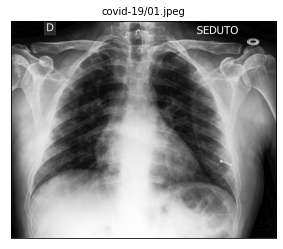

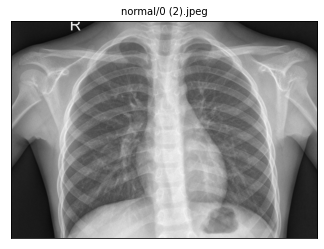

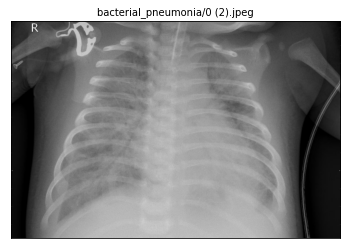

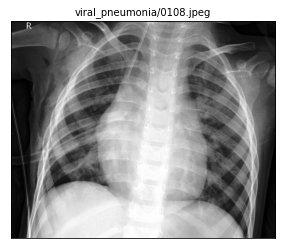

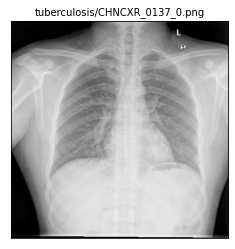

In [ ]:
# Displays first n images of class from training set
plot_defects_1("covid-19", 1, 1)
plot_defects_1("normal", 1, 1)
plot_defects_1("bacterial_pneumonia", 1, 1)
plot_defects_1("viral_pneumonia", 1, 1)
plot_defects_1("tuberculosis", 1, 1)

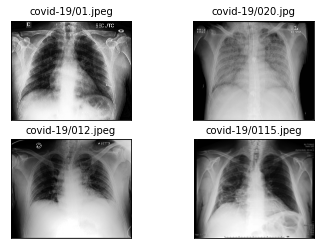

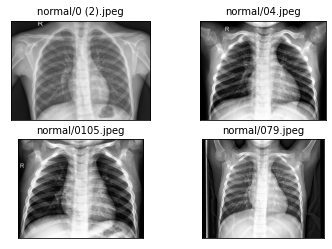

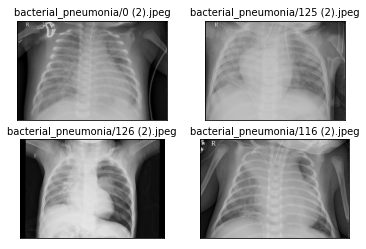

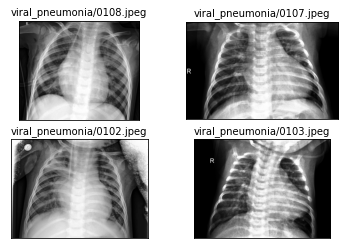

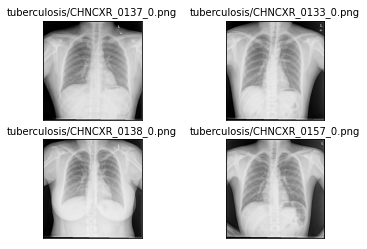

In [ ]:
# Displays first n images of class from training set
plot_defects("covid-19", 2, 2)
plot_defects("normal", 2, 2)
plot_defects("bacterial_pneumonia", 2, 2)
plot_defects("viral_pneumonia", 2, 2)
plot_defects("tuberculosis", 2, 2)

# Data loading from pickle saved files

In [ ]:
# rgb values / 255

import pickle as pkl

#to load it
with open("train_255_224.pkl", "rb") as f:
    X_train_255, Y_train = pkl.load(f)

with open("val_255_224.pkl", "rb") as f:
    X_val_255, Y_val = pkl.load(f)    
    
with open("test_255_224.pkl", "rb") as f:
    X_test_255, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1)

import pickle as pkl

#to load it
with open("train_224.pkl", "rb") as f:
    X_train, Y_train = pkl.load(f)

with open("val_224.pkl", "rb") as f:
    X_val, Y_val = pkl.load(f)
        
with open("test_224.pkl", "rb") as f:
    X_test, Y_test = pkl.load(f)

In [ ]:
# /255 divided + clahe

import pickle as pkl

#to load it
with open("train_CLAHE_255_224.pkl", "rb") as f:
    X_train_255_CLAHE, Y_train = pkl.load(f)

with open("val_CLAHE_255_224.pkl", "rb") as f:
    X_val_255_CLAHE, Y_val = pkl.load(f)    
    
with open("test_CLAHE_255_224.pkl", "rb") as f:
    X_test_255_CLAHE, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1 vals) + CLAHE preprocessing

import pickle as pkl

#to load it
with open("train_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_train_CLAHE, Y_train = pkl.load(f)

with open("val_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_val_CLAHE, Y_val = pkl.load(f)    
    
with open("test_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_test_CLAHE, Y_test = pkl.load(f)

# Data for fine-tuning loading from pickle saved files

In [ ]:
# rgb values / 255

import pickle as pkl

# to load it
with open("train_255_bigger.pkl", "rb") as f:
    X_train_255_ft, Y_train_ft = pkl.load(f)

with open("val_255_bigger.pkl", "rb") as f:
    X_val_255_ft, Y_val_ft = pkl.load(f)    
    
with open("test_255_224.pkl", "rb") as f:
    X_test_255, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1)

import pickle as pkl

#to load it
with open("train_bigger.pkl", "rb") as f:
    X_train_ft, Y_train_ft = pkl.load(f)

with open("val_bigger.pkl", "rb") as f:
    X_val_ft, Y_val_ft = pkl.load(f)
        
with open("test_224.pkl", "rb") as f:
    X_test, Y_test = pkl.load(f)

In [ ]:
# /255 divided + clahe

import pickle as pkl

#to load it
with open("train_CLAHE_255_bigger.pkl", "rb") as f:
    X_train_255_CLAHE_ft, Y_train_ft = pkl.load(f)

with open("val_CLAHE_255_bigger.pkl", "rb") as f:
    X_val_255_CLAHE_ft, Y_val_ft = pkl.load(f)    
    
with open("test_CLAHE_255_224.pkl", "rb") as f:
    X_test_255_CLAHE, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1 vals) + CLAHE preprocessing

import pickle as pkl

#to load it
with open("train_CLAHE_NORMALIZED_bigger.pkl", "rb") as f:
    X_train_CLAHE_ft, Y_train_ft = pkl.load(f)

with open("val_CLAHE_NORMALIZED_bigger.pkl", "rb") as f:
    X_val_CLAHE_ft, Y_val_ft = pkl.load(f)    
    
with open("test_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_test_CLAHE, Y_test = pkl.load(f)

# NO AUGMENATION on data divided by 255

In [ ]:
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_2, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 data scaled by 255.h5', verbose=2
                             ,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Fits the model on batches
hist = model.fit(X_train_255, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val)
                 )

Epoch 1/100
15/15 [==============================] - 17s 1s/step - loss: 1.9508 - accuracy: 0.2667 - val_loss: 1.4175 - val_accuracy: 0.5760

Epoch 00001: val_loss improved from inf to 1.41746, saving model to VGG19 data scaled by 255.h5
Epoch 2/100
15/15 [==============================] - 12s 366ms/step - loss: 1.4573 - accuracy: 0.4177 - val_loss: 1.3279 - val_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.41746 to 1.32790, saving model to VGG19 data scaled by 255.h5
Epoch 3/100
15/15 [==============================] - 5s 345ms/step - loss: 1.3065 - accuracy: 0.4818 - val_loss: 1.2571 - val_accuracy: 0.6240

Epoch 00003: val_loss improved from 1.32790 to 1.25710, saving model to VGG19 data scaled by 255.h5
Epoch 4/100
15/15 [==============================] - 5s 342ms/step - loss: 1.2171 - accuracy: 0.5310 - val_loss: 1.1874 - val_accuracy: 0.6880

Epoch 00004: val_loss improved from 1.25710 to 1.18737, saving model to VGG19 data scaled by 255.h5
Epoch 5/100
15/15 [==========

In [ ]:
del model
model = load_model('VGG19 data scaled by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

(125, 224, 224, 3)
4/4 [==============================] - 6s 1s/step - loss: 0.2912 - accuracy: 0.9280
Final Loss: 0.29122409224510193, Final Accuracy: 0.9279999732971191
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.91      0.80      0.85        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.88      0.84      0.86        25

           accuracy                           0.93       125
          macro avg       0.93      0.93      0.93       125
       weighted avg       0.93      0.93      0.93       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


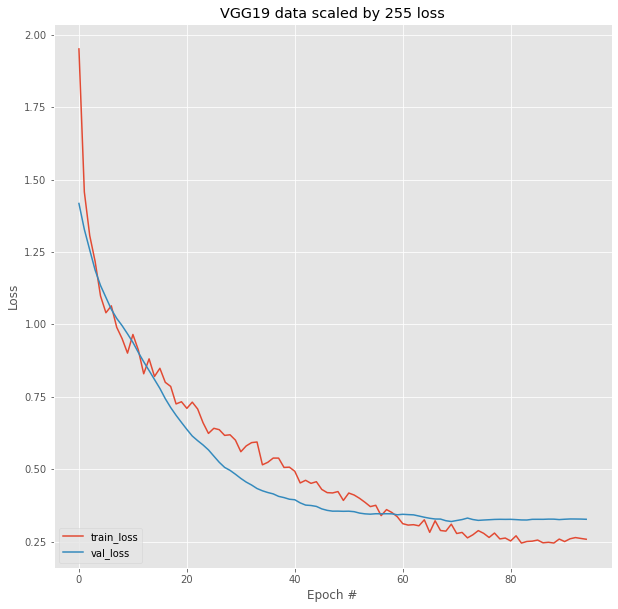

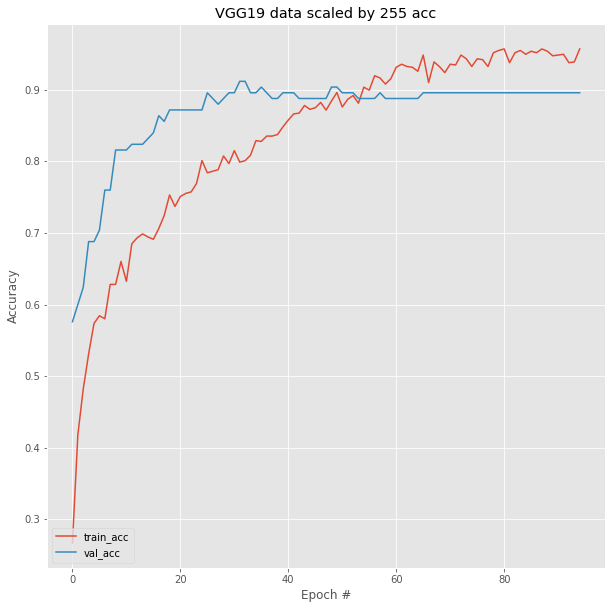

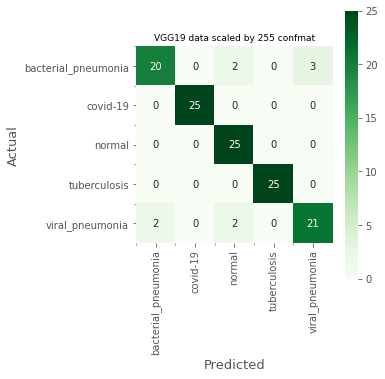

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 data scaled by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 data scaled by 255 acc')
plot_confusion_matrix('VGG19 data scaled by 255 confmat',Y_true, predIdxs, categories, False)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


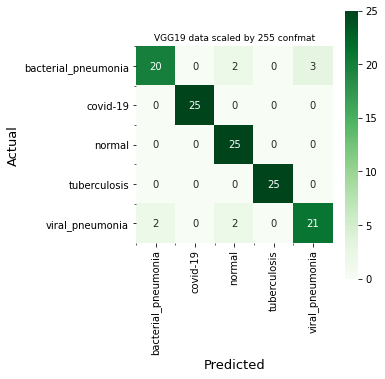

In [ ]:
plot_confusion_matrix('VGG19 data scaled by 255 confmat',Y_true, predIdxs, categories, False)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


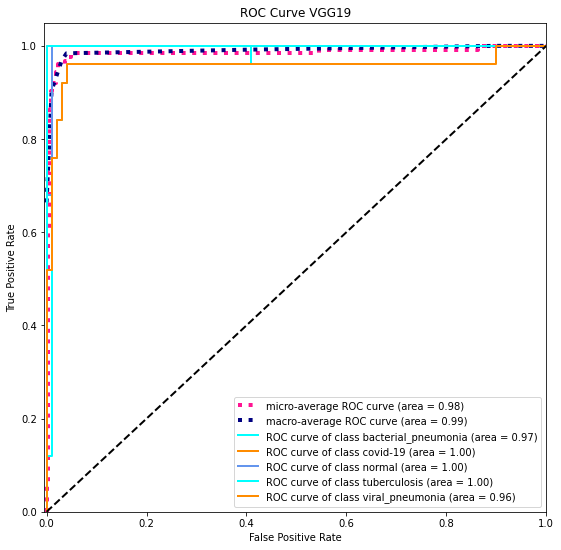

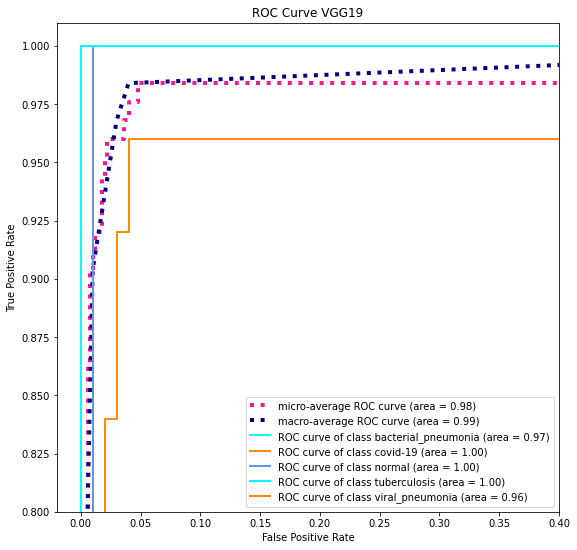

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19')

#FineTuning

**FineTuning on data divided by 255**

In [ ]:
# del model
model = load_model('VGG19 data scaled by 255.h5')

In [ ]:
for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_2, trainable: True
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 data scaled by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_255_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val))

model
(2400, 224, 224, 3)
(125, 224, 224, 3)
Epoch 1/100
37/37 [==============================] - 88s 1s/step - loss: 0.4850 - accuracy: 0.8568 - val_loss: 0.2451 - val_accuracy: 0.9433

Epoch 00001: val_loss improved from inf to 0.24514, saving model to FineTuned VGG19 data scaled by 255.h5
Epoch 2/100
37/37 [==============================] - 37s 718ms/step - loss: 0.4546 - accuracy: 0.8643 - val_loss: 0.2433 - val_accuracy: 0.9433

Epoch 00002: val_loss improved from 0.24514 to 0.24333, saving model to FineTuned VGG19 data scaled by 255.h5
Epoch 3/100
37/37 [==============================] - 26s 708ms/step - loss: 0.4306 - accuracy: 0.8737 - val_loss: 0.2307 - val_accuracy: 0.9433

Epoch 00003: val_loss improved from 0.24333 to 0.23072, saving model to FineTuned VGG19 data scaled by 255.h5
Epoch 4/100
37/37 [==============================] - 26s 709ms/step - loss: 0.4150 - accuracy: 0.8831 - val_loss: 0.2298 - val_accuracy: 0.9400

Epoch 00004: val_loss improved from 0.23072 to 0.229

In [ ]:
del model
model = load_model('FineTuned VGG19 data scaled by 255.h5')
final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning")
Y_pred = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred,target_names=categories))

4/4 [==============================] - 6s 1s/step - loss: 0.2064 - accuracy: 0.9440
Final Loss: 0.206426203250885, Final Accuracy: 0.9440000057220459
[INFO] evaluating after fine tuning
                     precision    recall  f1-score   support

bacterial_pneumonia       0.92      0.88      0.90        25
           covid-19       1.00      1.00      1.00        25
             normal       0.92      0.96      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.92      0.88      0.90        25

           accuracy                           0.94       125
          macro avg       0.94      0.94      0.94       125
       weighted avg       0.94      0.94      0.94       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


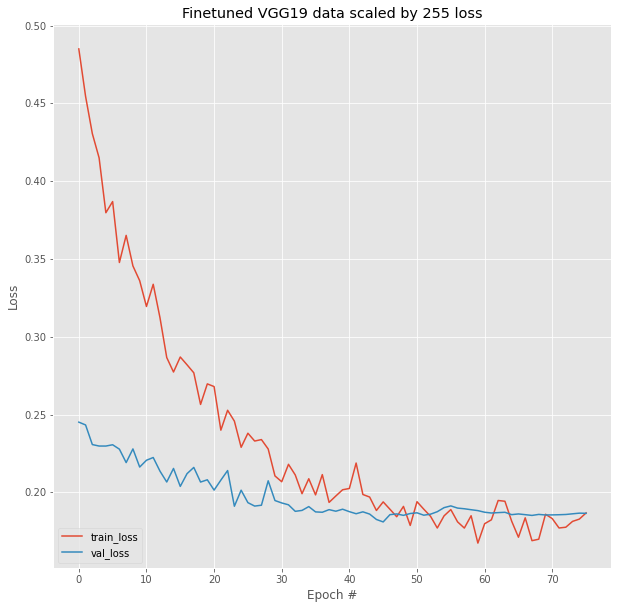

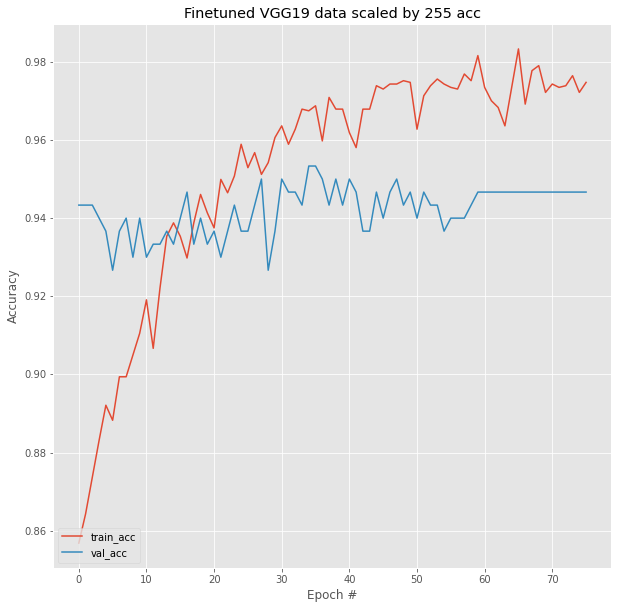

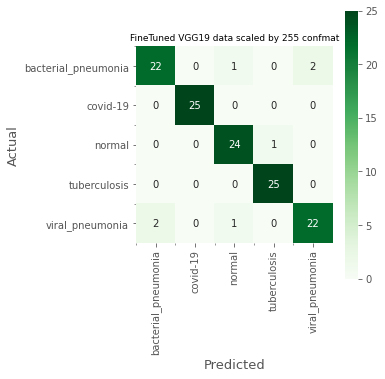

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned VGG19 data scaled by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned VGG19 data scaled by 255 acc')
plot_confusion_matrix('FineTuned VGG19 data scaled by 255 confmat',Y_true, Y_pred, categories, False)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


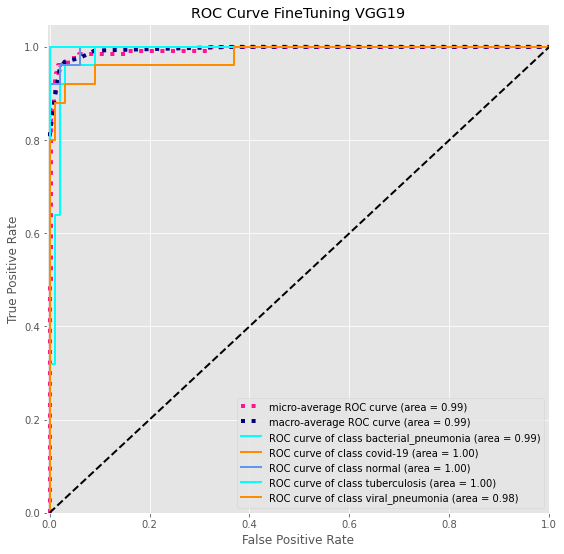

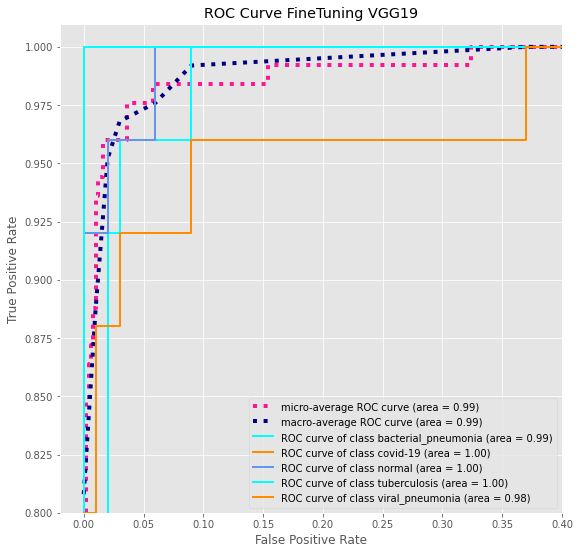

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19')

# Heatmap

In [ ]:
def get_activation_map(image_path, image_class_vector, loaded_model, final_conv_layer): 
        from tensorflow.keras.applications.mobilenet import preprocess_input
        import PIL, cv2
        import matplotlib.image as mpimg
        import matplotlib.pyplot as plt       
        img_size =224
        image_loaded = PIL.Image.open(image_path)
        image_loaded = image_loaded.resize((img_size, img_size))
        image_loaded = np.asarray(image_loaded)
      
        if len(image_loaded.shape) < 3:
          image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
        
        preprocessed_image = preprocess_input(image_loaded)
        # preprocessed_image = image_loaded
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        
        image_class = np.argmax(image_class_vector)

        class_weights = loaded_model.layers[-1].get_weights()[0]
        # final_conv_layer = loaded_model.layers[-3]
        
        get_output = tf.keras.backend.function([loaded_model.layers[0].input], 
                                               [final_conv_layer.output, loaded_model.layers[-1].output])
        
        [conv_outputs, predictions] = get_output(preprocessed_image)
        conv_outputs = conv_outputs[0, :, :, :]

        cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

        for index, weight in enumerate(class_weights[:, image_class]):
          cam += weight * conv_outputs[:, :, index]
        
        class_predicted = np.argmax(predictions[0])
        predictions = f'Class predicted: {class_predicted} | Real class: {image_class}'
        
        cam /= np.max(cam)
        cam = cv2.resize(cam, (img_size, img_size))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        
        img = heatmap * 0.5 + image_loaded
        cv2.imwrite("heatmap.jpg", img)
        
        heatmap = mpimg.imread("heatmap.jpg")
        
        scaled_image = (((img - img.min()) * 255) / (img.max() - img.min())).astype(np.uint8)

        cv2.imread(image_path)
        
        

        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(image_loaded)

        ax[0].set_title('Original image')

        ax[1].imshow(heatmap)
        ax[1].set_title(predictions)


In [ ]:
get_activation_map(train_dir + "/bacterial_pneumonia/person83_bacteria_412.jpeg", [1,0,0,0,0], model, model.get_layer('block4_conv3'))

FileNotFoundError: ignored

# NO AUGMENTATION on data normalized to (0-1)

**WITHOUT DATA AUGMENTATION TRAINING**

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True
optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 normalized set.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val, Y_val))


Epoch 1/100
15/15 [==============================] - 7s 404ms/step - loss: 2.1850 - accuracy: 0.2255 - val_loss: 1.5589 - val_accuracy: 0.2080

Epoch 00001: val_loss improved from inf to 1.55889, saving model to VGG19 normalized set.h5
Epoch 2/100
15/15 [==============================] - 6s 391ms/step - loss: 1.7737 - accuracy: 0.3060 - val_loss: 1.4293 - val_accuracy: 0.3520

Epoch 00002: val_loss improved from 1.55889 to 1.42931, saving model to VGG19 normalized set.h5
Epoch 3/100
15/15 [==============================] - 6s 394ms/step - loss: 1.4541 - accuracy: 0.4197 - val_loss: 1.3418 - val_accuracy: 0.4800

Epoch 00003: val_loss improved from 1.42931 to 1.34176, saving model to VGG19 normalized set.h5
Epoch 4/100
15/15 [==============================] - 6s 403ms/step - loss: 1.3398 - accuracy: 0.4697 - val_loss: 1.2698 - val_accuracy: 0.5760

Epoch 00004: val_loss improved from 1.34176 to 1.26978, saving model to VGG19 normalized set.h5
Epoch 5/100
15/15 [=========================

4/4 [==============================] - 5s 1s/step - loss: 0.2737 - accuracy: 0.9280
Final Loss: 0.27367785573005676, Final Accuracy: 0.9279999732971191
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.88      0.86        25
           covid-19       1.00      1.00      1.00        25
             normal       0.89      1.00      0.94        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.90      0.76      0.83        25

           accuracy                           0.93       125
          macro avg       0.93      0.93      0.93       125
       weighted avg       0.93      0.93      0.93       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


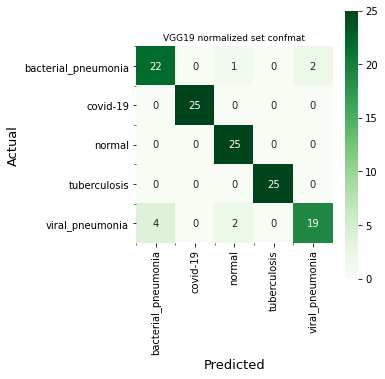

In [ ]:
del model
model = load_model('VGG19 normalized set.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories
))

plot_confusion_matrix('VGG19 normalized set confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


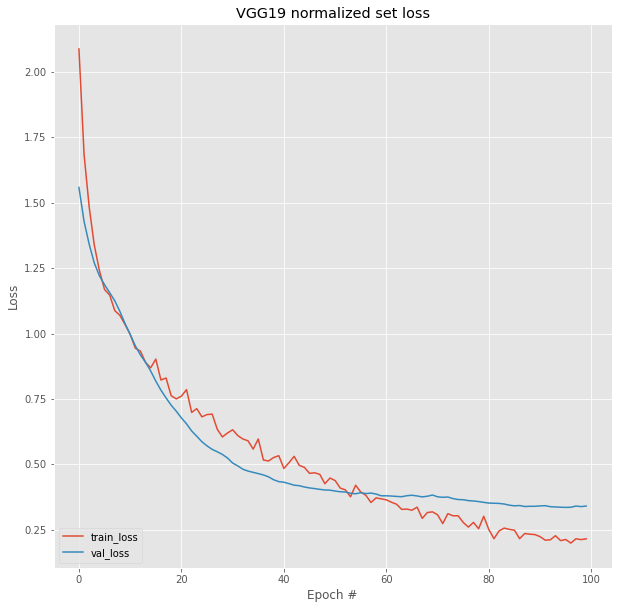

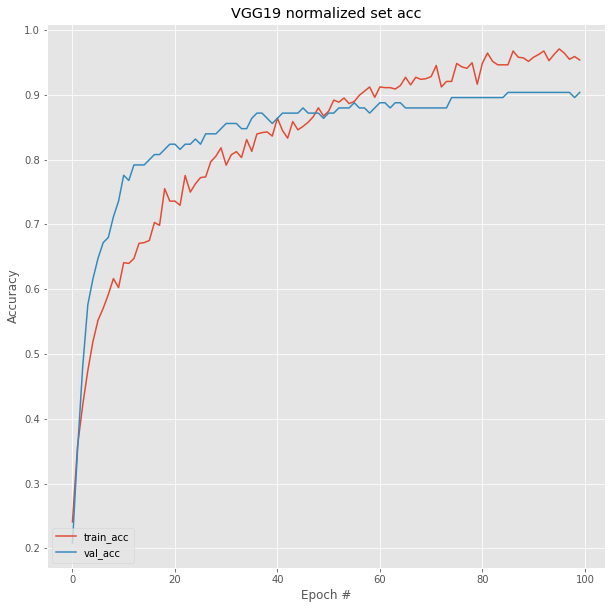

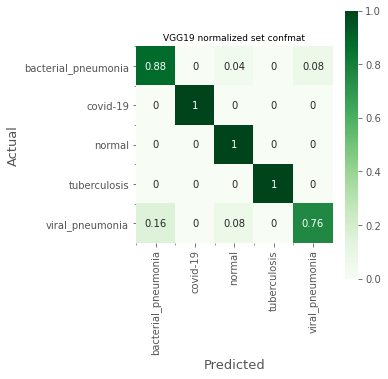

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 normalized set acc')
plot_confusion_matrix('VGG19 normalized set confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


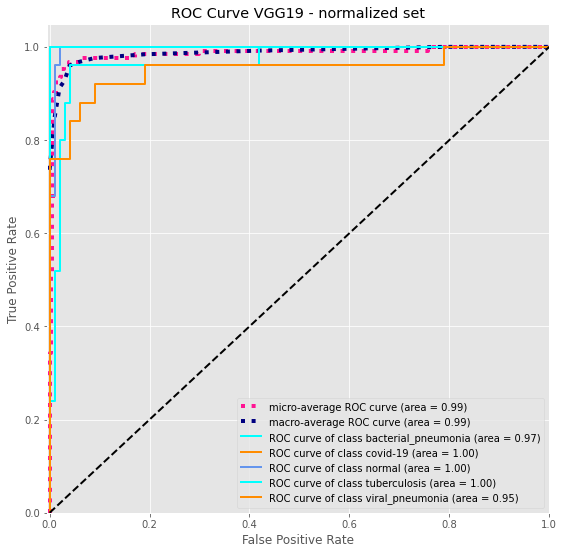

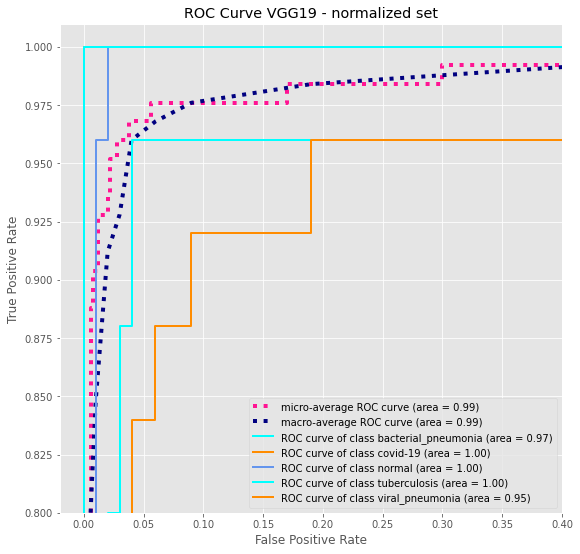

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 - normalized set')

#FineTuning

**FineTuning on normal data without hist equalization and without augmentation**

In [ ]:
del model
model = load_model('VGG19 normalized set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:-17]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 88s 1s/step - loss: 0.4740 - accuracy: 0.8661 - val_loss: 0.2454 - val_accuracy: 0.9333

Epoch 00001: val_loss improved from inf to 0.24537, saving model to FineTuned VGG19 normalized set.h5
Epoch 2/100
37/37 [==============================] - 37s 720ms/step - loss: 0.4444 - accuracy: 0.8733 - val_loss: 0.2371 - val_accuracy: 0.9433

Epoch 00002: val_loss improved from 0.24537 to 0.23706, saving model to FineTuned VGG19 normalized set.h5
Epoch 3/100
37/37 [==============================] - 26s 711ms/step - loss: 0.3838 - accuracy: 0.8930 - val_loss: 0.2340 - val_accuracy: 0.9233

Epoch 00003: val_loss improved from 0.23706 to 0.23396, saving model to FineTuned VGG19 normalized set.h5
Epoch 4/100
37/37 [==============================] - 26s 713ms/step - loss: 0.3504 - accuracy: 0.9020 - val_loss: 0.2289 - val_accuracy: 0.9267

Epoch 00004: val_loss improved from 0.23396 to 0.22894, saving model to FineTuned VGG19 normalized set.

In [ ]:
del model
model = load_model('FineTuned VGG19 normalized set.h5')
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

# predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 27s 6s/step - loss: 0.2016 - accuracy: 0.9440
Final Loss: 0.20157457888126373, Final Accuracy: 0.9440000057220459
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.88      0.92      0.90        25
           covid-19       1.00      1.00      1.00        25
             normal       0.92      0.96      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.95      0.84      0.89        25

           accuracy                           0.94       125
          macro avg       0.94      0.94      0.94       125
       weighted avg       0.94      0.94      0.94       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


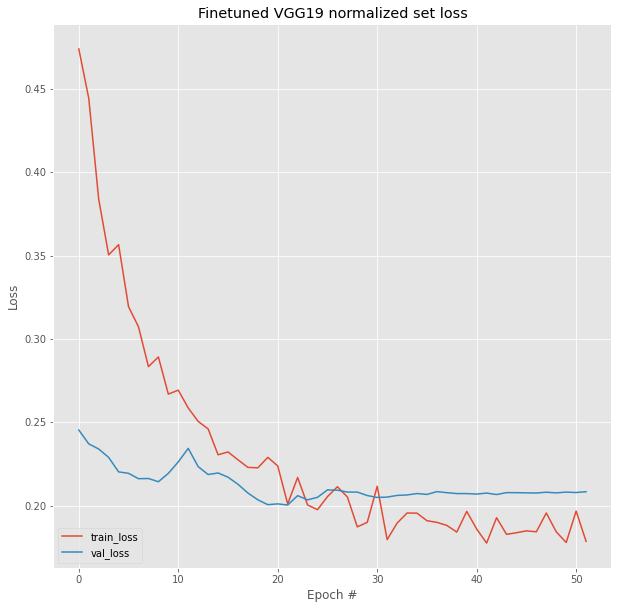

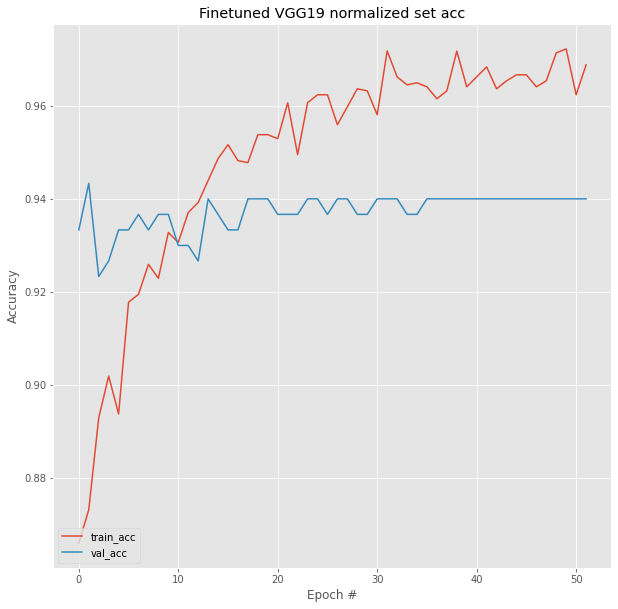

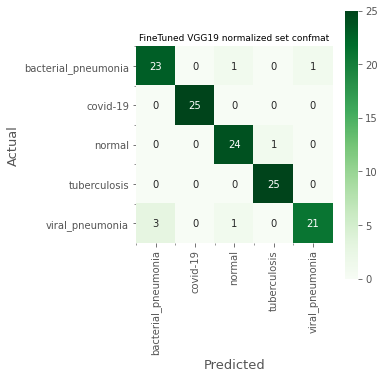

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned VGG19 normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned VGG19 normalized set acc')
plot_confusion_matrix('FineTuned VGG19 normalized set confmat',Y_true, Y_pred, categories, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


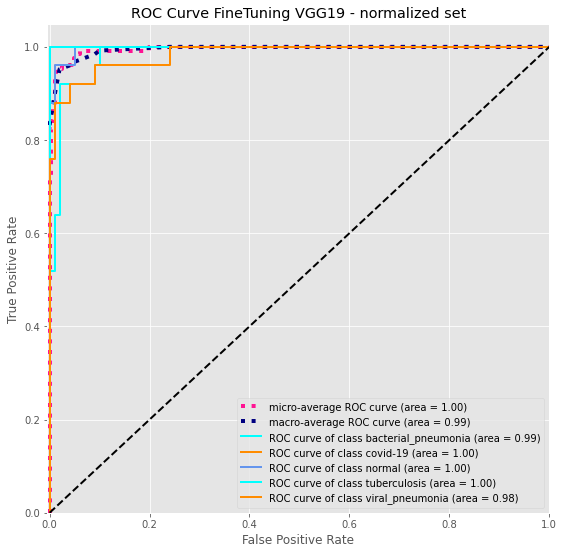

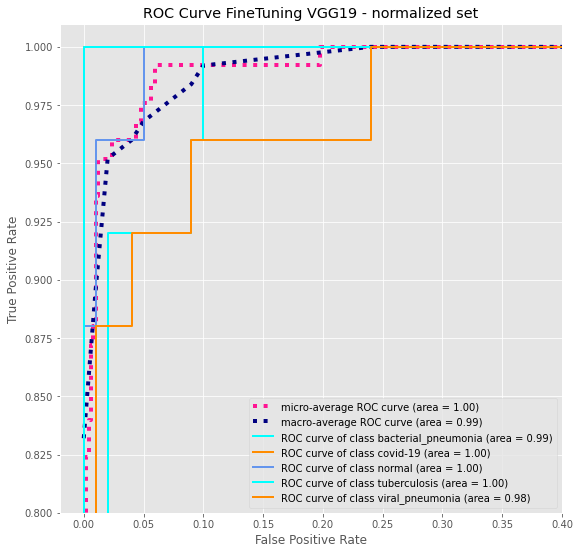

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 - normalized set')

# NO AUGMENTATION on data divided by 255 + CLAHE processed

**After CLAHE processing without data augmentation**

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 CLAHE set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train_255_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 7s 379ms/step - loss: 2.0994 - accuracy: 0.2107 - val_loss: 1.5117 - val_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 1.51171, saving model to VGG19 CLAHE set.h5
Epoch 2/100
15/15 [==============================] - 5s 364ms/step - loss: 1.5309 - accuracy: 0.3927 - val_loss: 1.3461 - val_accuracy: 0.5520

Epoch 00002: val_loss improved from 1.51171 to 1.34607, saving model to VGG19 CLAHE set.h5
Epoch 3/100
15/15 [==============================] - 5s 360ms/step - loss: 1.4247 - accuracy: 0.4482 - val_loss: 1.2704 - val_accuracy: 0.6080

Epoch 00003: val_loss improved from 1.34607 to 1.27041, saving model to VGG19 CLAHE set.h5
Epoch 4/100
15/15 [==============================] - 5s 364ms/step - loss: 1.2433 - accuracy: 0.5225 - val_loss: 1.2167 - val_accuracy: 0.6480

Epoch 00004: val_loss improved from 1.27041 to 1.21668, saving model to VGG19 CLAHE set.h5
Epoch 5/100
15/15 [==============================] - 5s 367ms/st

4/4 [==============================] - 5s 1s/step - loss: 0.2673 - accuracy: 0.9360
Final Loss: 0.2672543227672577, Final Accuracy: 0.9359999895095825
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.88      0.88      0.88        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.95      0.80      0.87        25

           accuracy                           0.94       125
          macro avg       0.94      0.94      0.94       125
       weighted avg       0.94      0.94      0.94       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


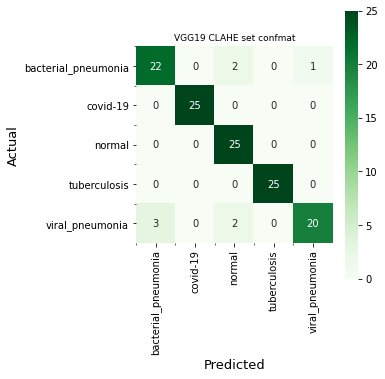

In [ ]:
del model
model = load_model('VGG19 CLAHE set.h5')

final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('VGG19 CLAHE set confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


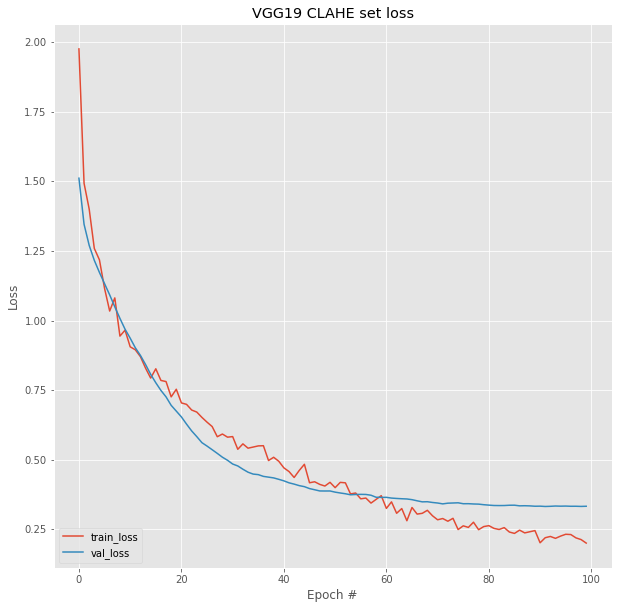

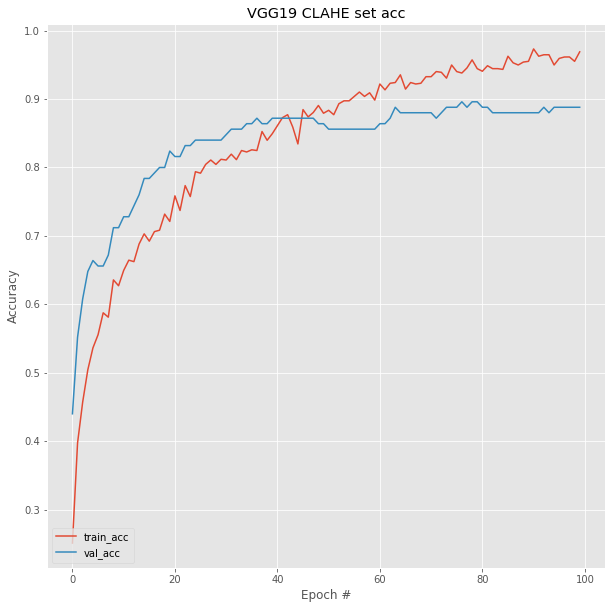

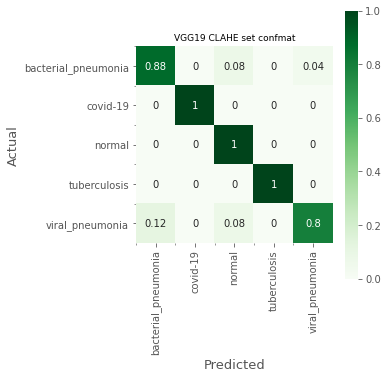

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 CLAHE set loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 CLAHE set acc')
plot_confusion_matrix('VGG19 CLAHE set confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


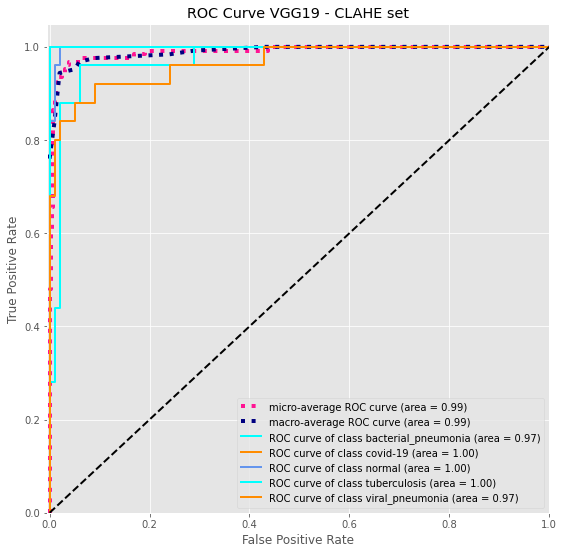

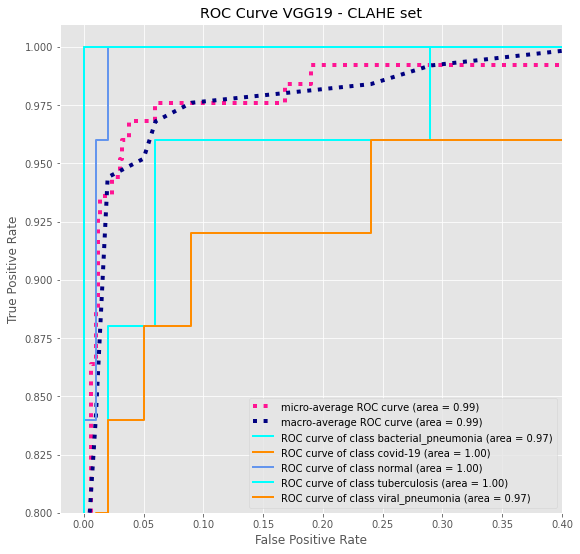

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 - CLAHE set')

#FineTuning

**FineTuning on CLAHE and /255**

In [ ]:
model = load_model('VGG19 CLAHE set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

print(optimizer.learning_rate)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 CLAHE set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_255_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE_ft, Y_val_ft))



model
Epoch 1/100
37/37 [==============================] - 89s 1s/step - loss: 0.4418 - accuracy: 0.8720 - val_loss: 0.2293 - val_accuracy: 0.9300

Epoch 00001: val_loss improved from inf to 0.22932, saving model to FineTuned VGG19 CLAHE set.h5
Epoch 2/100
37/37 [==============================] - 37s 726ms/step - loss: 0.4096 - accuracy: 0.8793 - val_loss: 0.2157 - val_accuracy: 0.9367

Epoch 00002: val_loss improved from 0.22932 to 0.21567, saving model to FineTuned VGG19 CLAHE set.h5
Epoch 3/100
37/37 [==============================] - 27s 719ms/step - loss: 0.3824 - accuracy: 0.8814 - val_loss: 0.2136 - val_accuracy: 0.9400

Epoch 00003: val_loss improved from 0.21567 to 0.21356, saving model to FineTuned VGG19 CLAHE set.h5
Epoch 4/100
37/37 [==============================] - 27s 719ms/step - loss: 0.3453 - accuracy: 0.9054 - val_loss: 0.2220 - val_accuracy: 0.9367

Epoch 00004: val_loss did not improve from 0.21356
Epoch 5/100
37/37 [==============================] - 26s 717ms/step

In [ ]:
del model
model = load_model('FineTuned VGG19 CLAHE set.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 26s 6s/step - loss: 0.2018 - accuracy: 0.9360
Final Loss: 0.20182913541793823, Final Accuracy: 0.9359999895095825
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.91      0.84      0.87        25
           covid-19       1.00      1.00      1.00        25
             normal       0.96      0.92      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.85      0.92      0.88        25

           accuracy                           0.94       125
          macro avg       0.94      0.94      0.94       125
       weighted avg       0.94      0.94      0.94       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


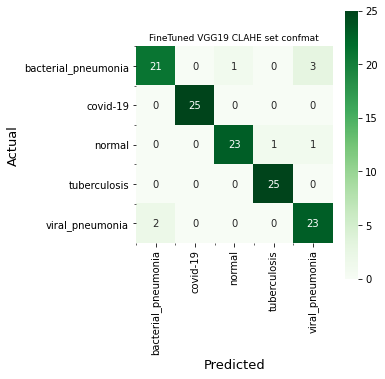

In [ ]:
plot_confusion_matrix('FineTuned VGG19 CLAHE set confmat', Y_true, Y_pred, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


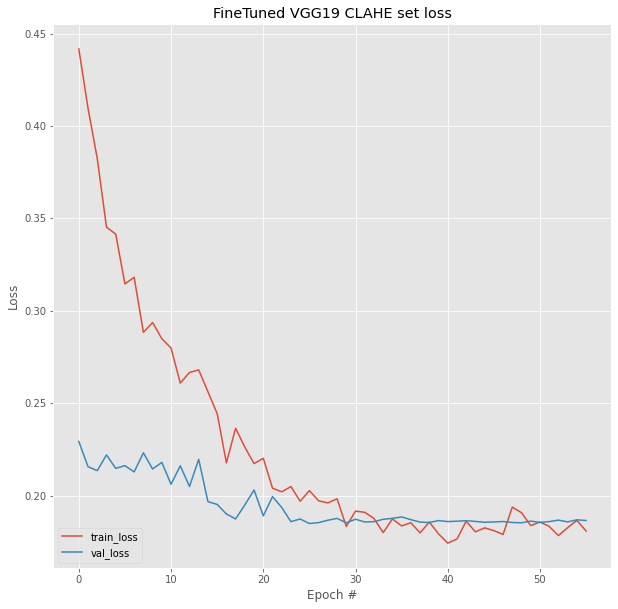

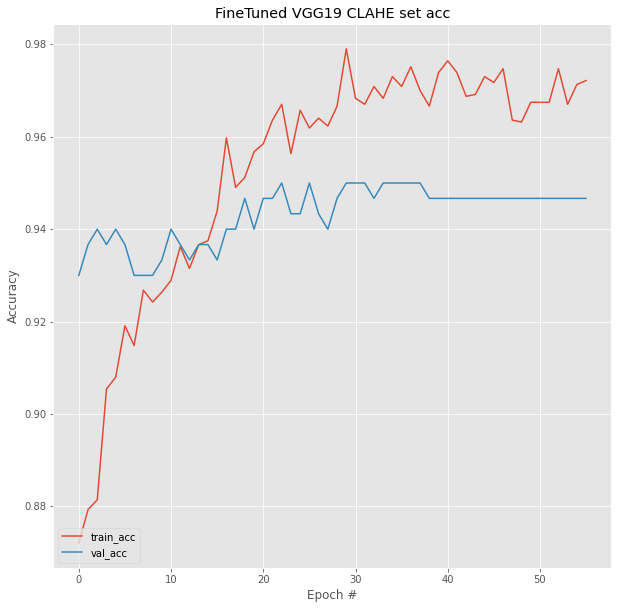

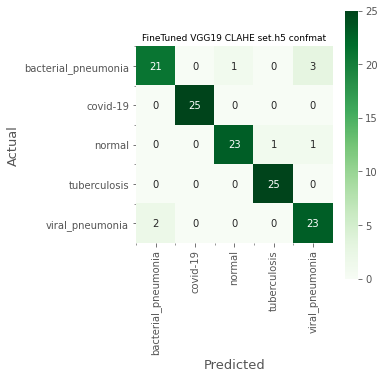

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned VGG19 CLAHE set loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned VGG19 CLAHE set acc')
plot_confusion_matrix('FineTuned VGG19 CLAHE set.h5 confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


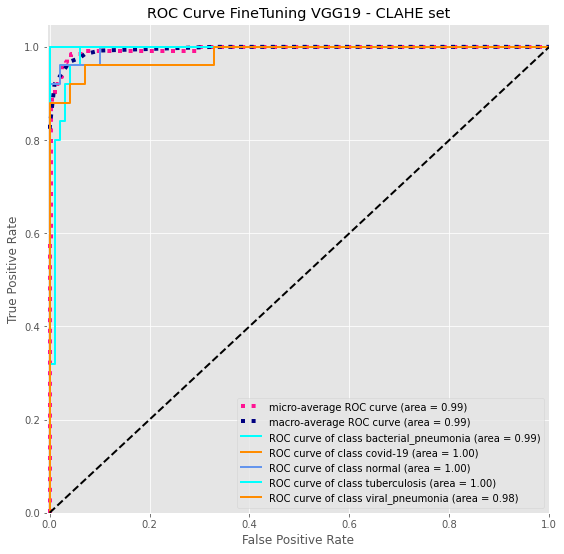

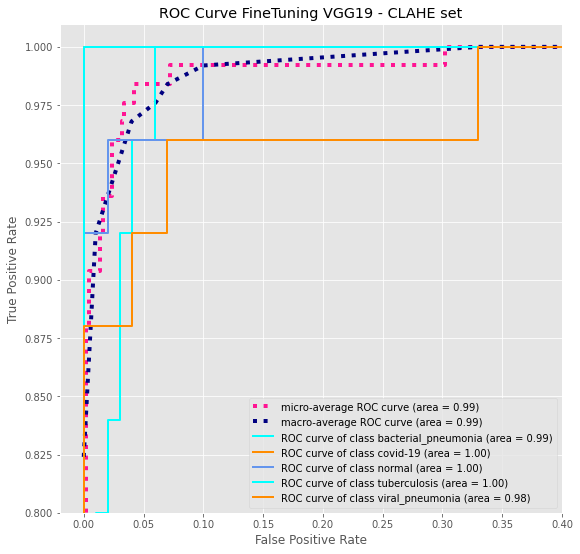

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 - CLAHE set')

# NO AUGMENTATION on data normalized to (0-1) + CLAHE processed

**After CLAHE processing without data augmentation**

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 CLAHE + normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 7s 377ms/step - loss: 2.0262 - accuracy: 0.2501 - val_loss: 1.4837 - val_accuracy: 0.3120

Epoch 00001: val_loss improved from inf to 1.48373, saving model to VGG19 CLAHE + normalized set.h5
Epoch 2/100
15/15 [==============================] - 5s 359ms/step - loss: 1.6028 - accuracy: 0.3770 - val_loss: 1.3433 - val_accuracy: 0.4720

Epoch 00002: val_loss improved from 1.48373 to 1.34331, saving model to VGG19 CLAHE + normalized set.h5
Epoch 3/100
15/15 [==============================] - 5s 359ms/step - loss: 1.4053 - accuracy: 0.4598 - val_loss: 1.2670 - val_accuracy: 0.6080

Epoch 00003: val_loss improved from 1.34331 to 1.26699, saving model to VGG19 CLAHE + normalized set.h5
Epoch 4/100
15/15 [==============================] - 5s 361ms/step - loss: 1.2911 - accuracy: 0.5183 - val_loss: 1.2046 - val_accuracy: 0.7040

Epoch 00004: val_loss improved from 1.26699 to 1.20459, saving model to VGG19 CLAHE + normalized set.h5
Epoch 5/100


4/4 [==============================] - 5s 1s/step - loss: 0.2795 - accuracy: 0.9200
Final Loss: 0.27952784299850464, Final Accuracy: 0.9200000166893005
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.88      0.86        25
           covid-19       1.00      1.00      1.00        25
             normal       0.83      1.00      0.91        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.95      0.72      0.82        25

           accuracy                           0.92       125
          macro avg       0.93      0.92      0.92       125
       weighted avg       0.93      0.92      0.92       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


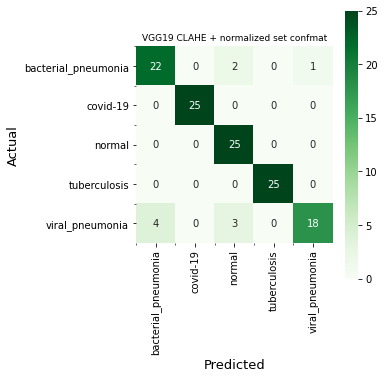

In [ ]:
del model
model = load_model('VGG19 CLAHE + normalized set.h5')

final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('VGG19 CLAHE + normalized set confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


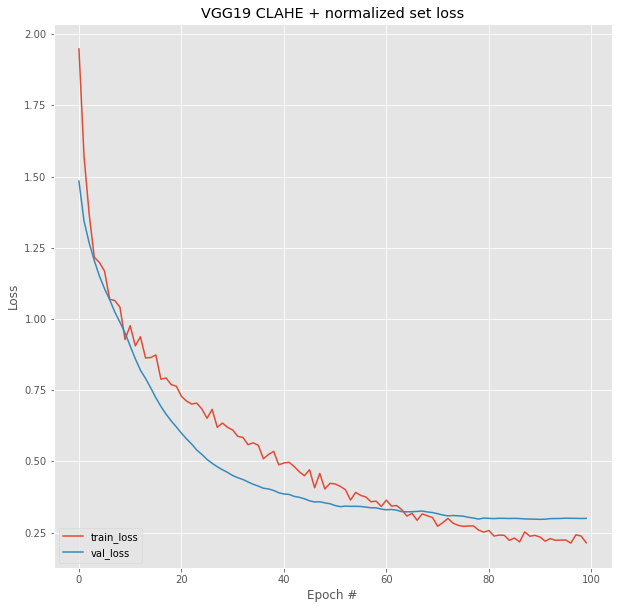

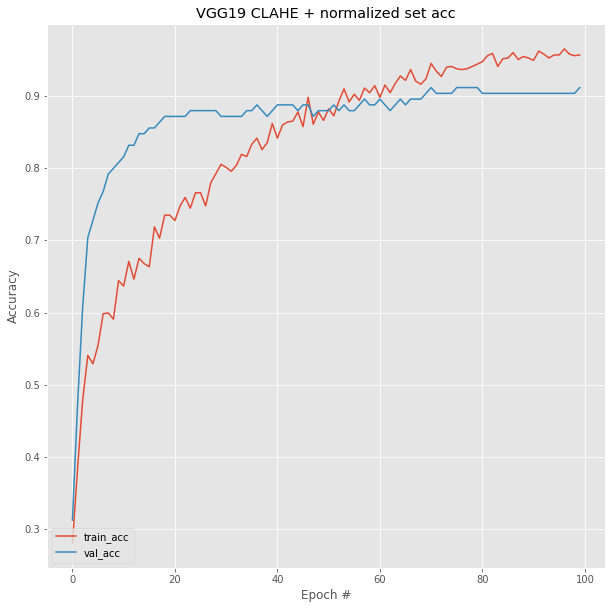

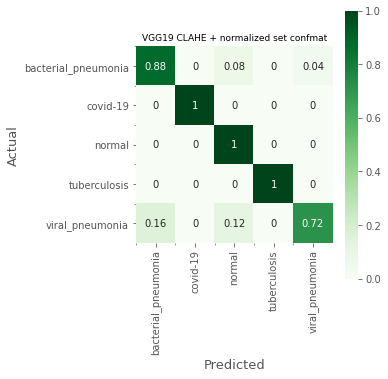

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 CLAHE + normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 CLAHE + normalized set acc')
plot_confusion_matrix('VGG19 CLAHE + normalized set confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


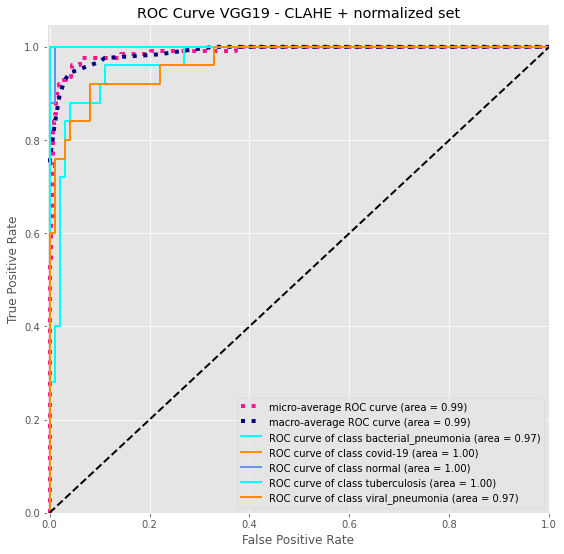

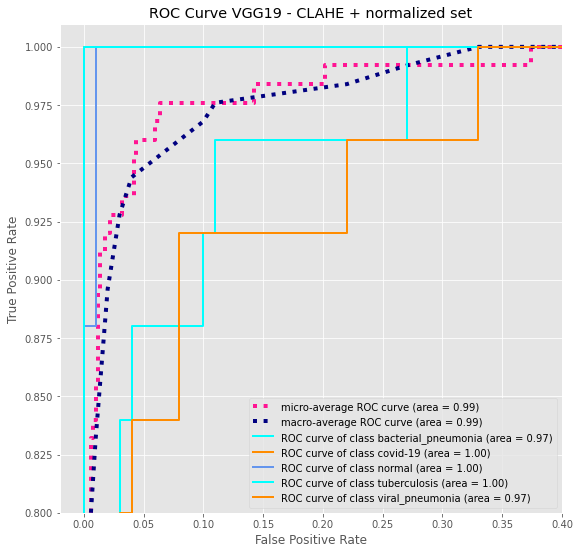

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 - CLAHE + normalized set')

#FineTuning

**FineTuning VGG19 on normal data without hist equalization and without augmentation**

In [ ]:
# del model
model = load_model('VGG19 CLAHE + normalized set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

print(optimizer.learning_rate)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 CLAHE + normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE_ft, Y_val_ft))



model
Epoch 1/100
37/37 [==============================] - 64s 603ms/step - loss: 0.4846 - accuracy: 0.8530 - val_loss: 0.2247 - val_accuracy: 0.9433

Epoch 00001: val_loss improved from inf to 0.22471, saving model to FineTuned VGG19 CLAHE + normalized set.h5
Epoch 2/100
37/37 [==============================] - 22s 416ms/step - loss: 0.4052 - accuracy: 0.8784 - val_loss: 0.2057 - val_accuracy: 0.9500

Epoch 00002: val_loss improved from 0.22471 to 0.20567, saving model to FineTuned VGG19 CLAHE + normalized set.h5
Epoch 3/100
37/37 [==============================] - 16s 424ms/step - loss: 0.3830 - accuracy: 0.8913 - val_loss: 0.2252 - val_accuracy: 0.9400

Epoch 00003: val_loss did not improve from 0.20567
Epoch 4/100
37/37 [==============================] - 16s 428ms/step - loss: 0.3730 - accuracy: 0.8985 - val_loss: 0.2124 - val_accuracy: 0.9400

Epoch 00004: val_loss did not improve from 0.20567
Epoch 5/100
37/37 [==============================] - 15s 417ms/step - loss: 0.3411 - acc

In [ ]:
del model
model = load_model('FineTuned VGG19 CLAHE + normalized set.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 26s 6s/step - loss: 0.2394 - accuracy: 0.9280
Final Loss: 0.2393878698348999, Final Accuracy: 0.9279999732971191
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.91      0.84      0.87        25

           accuracy                           0.93       125
          macro avg       0.93      0.93      0.93       125
       weighted avg       0.93      0.93      0.93       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


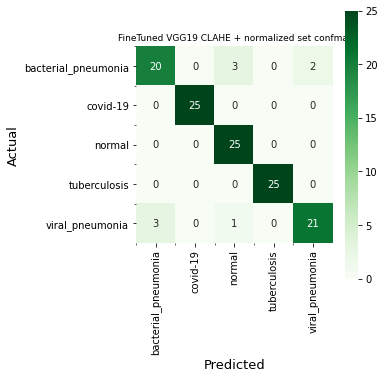

In [ ]:
plot_confusion_matrix('FineTuned VGG19 CLAHE + normalized set confmat',Y_true, Y_pred, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


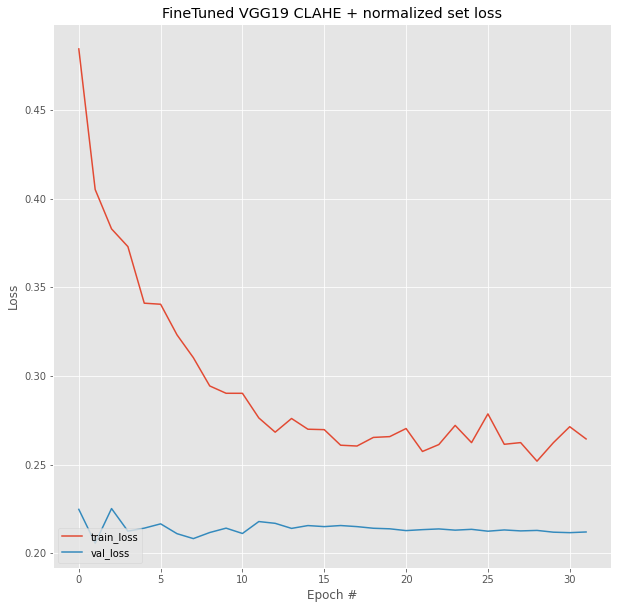

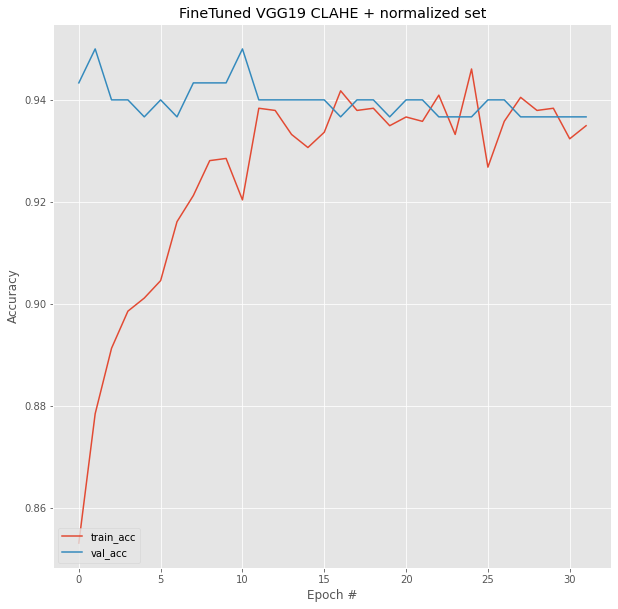

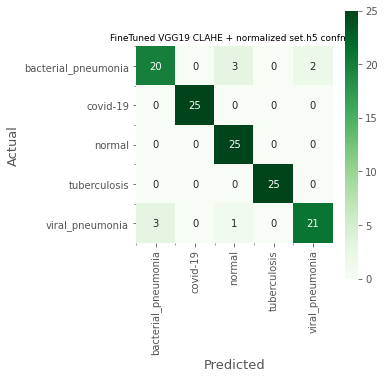

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned VGG19 CLAHE + normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned VGG19 CLAHE + normalized set')
plot_confusion_matrix('FineTuned VGG19 CLAHE + normalized set.h5 confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


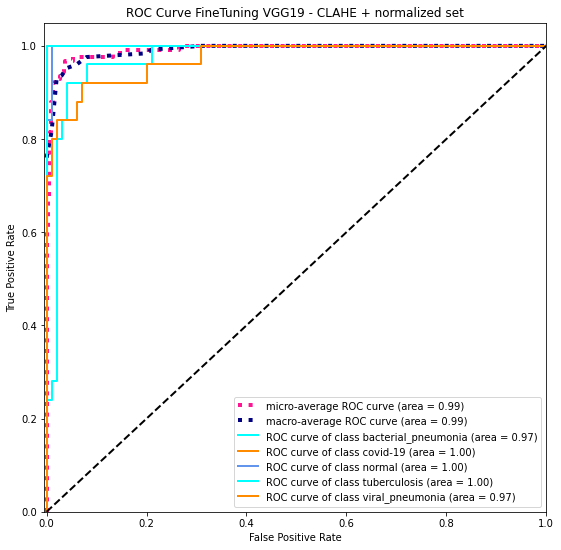

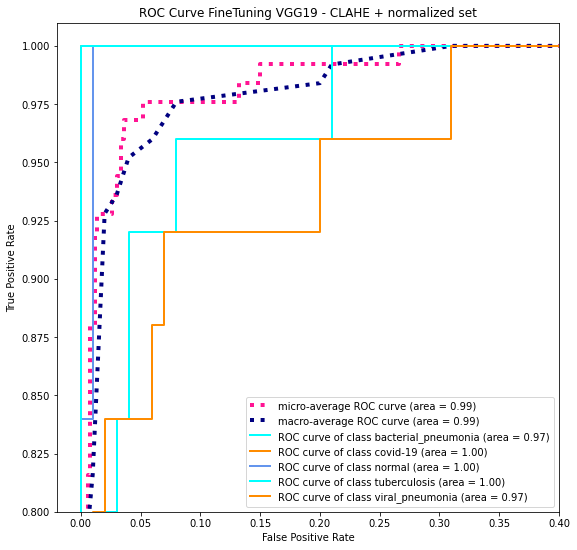

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 - CLAHE + normalized set')

# AUGMENTATION on data divided by 255

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 Augmentation on data divided by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode = "nearest")  # Randomly flip inputs vertically

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 758ms/step - loss: 2.1971 - accuracy: 0.2103 - val_loss: 1.5523 - val_accuracy: 0.2160

Epoch 00001: val_loss improved from inf to 1.55231, saving model to VGG19 Augmentation on data divided by 255.h5
Epoch 2/100
15/15 [==============================] - 11s 751ms/step - loss: 1.7195 - accuracy: 0.3200 - val_loss: 1.4448 - val_accuracy: 0.3520

Epoch 00002: val_loss improved from 1.55231 to 1.44481, saving model to VGG19 Augmentation on data divided by 255.h5
Epoch 3/100
15/15 [==============================] - 11s 749ms/step - loss: 1.4445 - accuracy: 0.4099 - val_loss: 1.3473 - val_accuracy: 0.5120

Epoch 00003: val_loss improved from 1.44481 to 1.34733, saving model to VGG19 Augmentation on data divided by 255.h5
Epoch 4/100
15/15 [==============================] - 11s 729ms/step - loss: 1.3614 - accuracy: 0.4515 - val_loss: 1.2477 - val_accuracy: 0.5920

Epoch 00004: val_loss improved from 1.34733 to 1.24771, saving model to V

4/4 [==============================] - 5s 1s/step - loss: 0.2843 - accuracy: 0.9200
Final Loss: 0.284291535615921, Final Accuracy: 0.9200000166893005
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.89      0.96      0.92        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.88      0.84      0.86        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


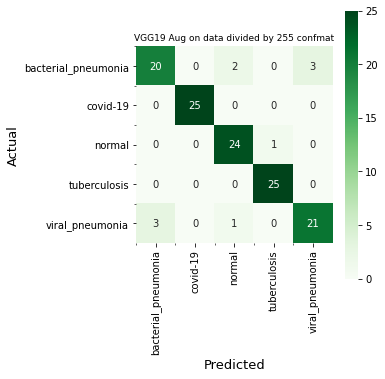

In [ ]:
del model
model = load_model('VGG19 Augmentation on data divided by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('VGG19 Aug on data divided by 255 confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


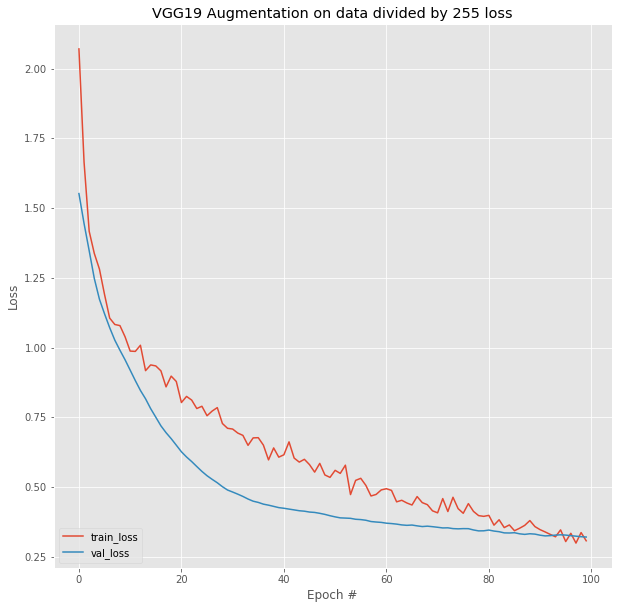

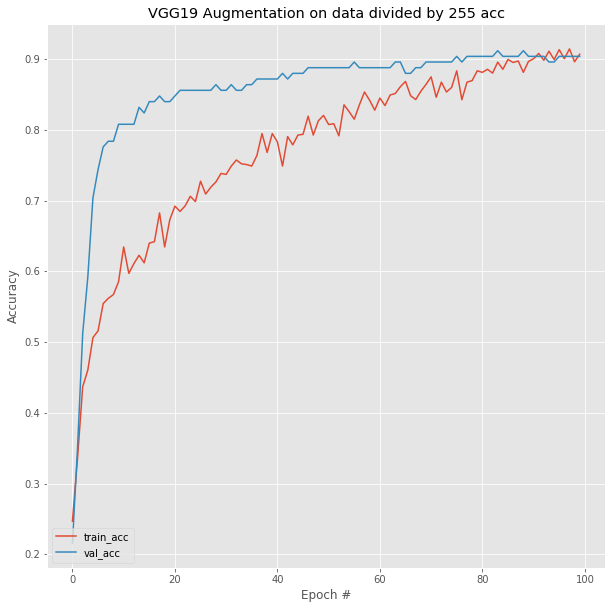

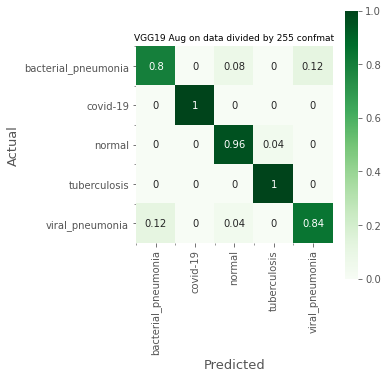

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 Augmentation on data divided by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 Augmentation on data divided by 255 acc')
plot_confusion_matrix('VGG19 Aug on data divided by 255 confmat',Y_true, predIdxs, categories)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


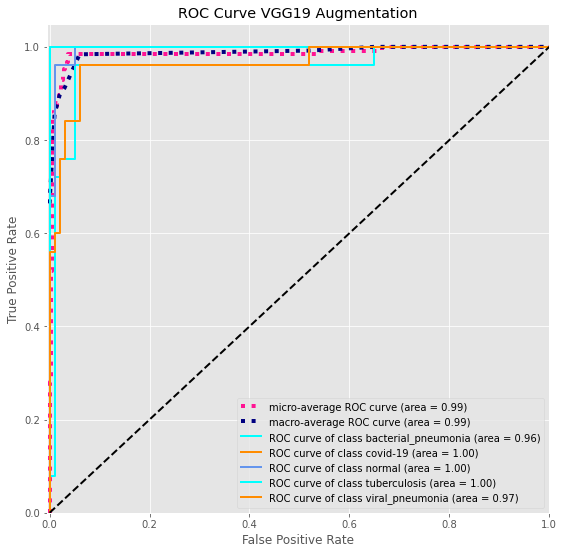

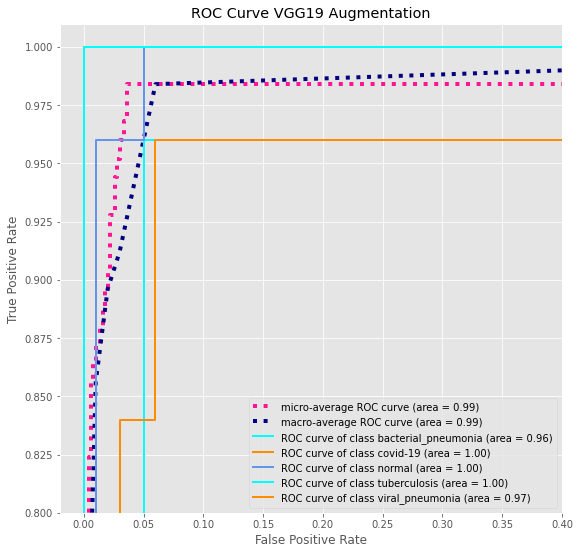

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 Augmentation')

#FineTuning

In [ ]:
del model
model = load_model('VGG19 Augmentation on data divided by 255.h5')

In [ ]:
for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: True
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 Augmentation on data divided by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode = "nearest"
)

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_ft, Y_val_ft))



model
Epoch 1/100
37/37 [==============================] - 30s 750ms/step - loss: 0.4400 - accuracy: 0.8545 - val_loss: 0.2370 - val_accuracy: 0.9300

Epoch 00001: val_loss improved from inf to 0.23696, saving model to FineTuned VGG19 Augmentation on data divided by 255.h5
Epoch 2/100
37/37 [==============================] - 27s 718ms/step - loss: 0.4447 - accuracy: 0.8613 - val_loss: 0.2274 - val_accuracy: 0.9400

Epoch 00002: val_loss improved from 0.23696 to 0.22742, saving model to FineTuned VGG19 Augmentation on data divided by 255.h5
Epoch 3/100
37/37 [==============================] - 26s 701ms/step - loss: 0.4120 - accuracy: 0.8703 - val_loss: 0.2275 - val_accuracy: 0.9367

Epoch 00003: val_loss did not improve from 0.22742
Epoch 4/100
37/37 [==============================] - 26s 700ms/step - loss: 0.4186 - accuracy: 0.8647 - val_loss: 0.2320 - val_accuracy: 0.9400

Epoch 00004: val_loss did not improve from 0.22742
Epoch 5/100
37/37 [==============================] - 26s 700ms

In [ ]:
del model
model = load_model('FineTuned VGG19 Augmentation on data divided by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning network...")

Y_pred = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 26s 6s/step - loss: 0.2502 - accuracy: 0.9360
Final Loss: 0.2502448260784149, Final Accuracy: 0.9359999895095825
[INFO] evaluating after fine tuning network...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.88      0.88      0.88        25
           covid-19       1.00      1.00      1.00        25
             normal       0.89      0.96      0.92        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.95      0.84      0.89        25

           accuracy                           0.94       125
          macro avg       0.94      0.94      0.94       125
       weighted avg       0.94      0.94      0.94       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


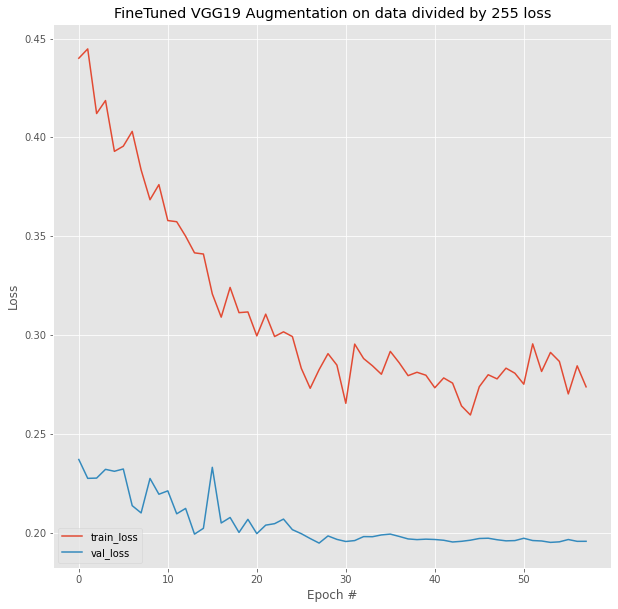

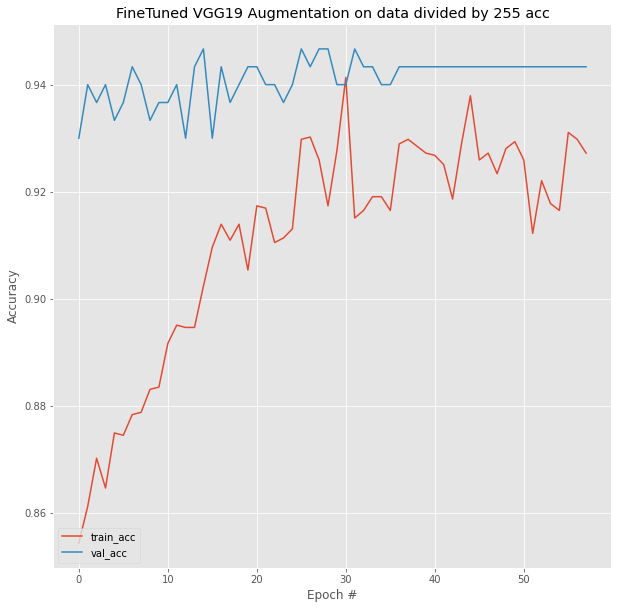

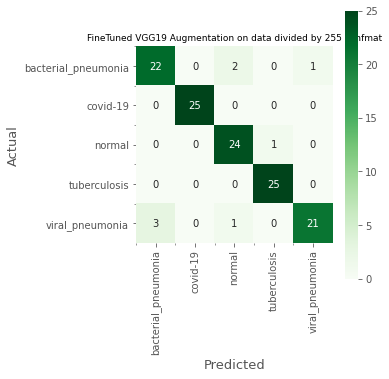

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned VGG19 Augmentation on data divided by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned VGG19 Augmentation on data divided by 255 acc')
plot_confusion_matrix('FineTuned VGG19 Augmentation on data divided by 255 confmat', Y_true, Y_pred, categories, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


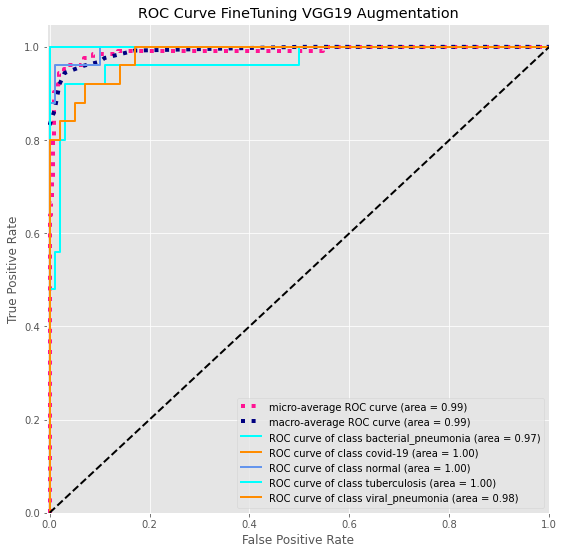

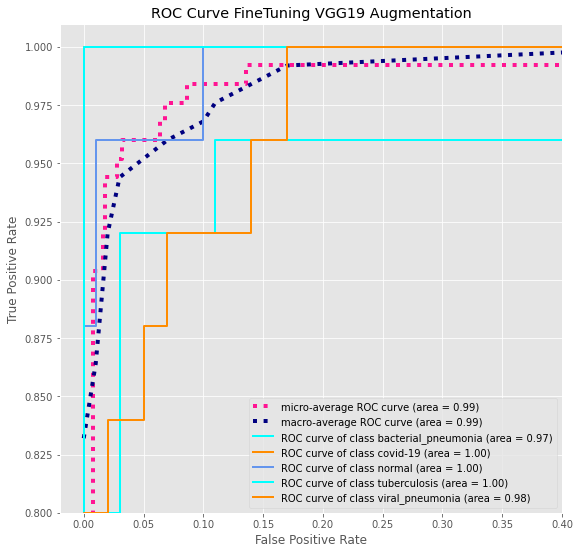

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 Augmentation')

# AUGMENTATION on data normalized to (0-1)

**Transfer learning on VGG19 before hist manipulation**

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 Augmentation normalized.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode='nearest'
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 766ms/step - loss: 2.1871 - accuracy: 0.1875 - val_loss: 1.6119 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.61188, saving model to VGG19 Augmentation normalized.h5
Epoch 2/100
15/15 [==============================] - 11s 738ms/step - loss: 1.7333 - accuracy: 0.2991 - val_loss: 1.5256 - val_accuracy: 0.2080

Epoch 00002: val_loss improved from 1.61188 to 1.52559, saving model to VGG19 Augmentation normalized.h5
Epoch 3/100
15/15 [==============================] - 11s 747ms/step - loss: 1.4241 - accuracy: 0.4396 - val_loss: 1.4263 - val_accuracy: 0.5040

Epoch 00003: val_loss improved from 1.52559 to 1.42631, saving model to VGG19 Augmentation normalized.h5
Epoch 4/100
15/15 [==============================] - 11s 742ms/step - loss: 1.3327 - accuracy: 0.4435 - val_loss: 1.3372 - val_accuracy: 0.6320

Epoch 00004: val_loss improved from 1.42631 to 1.33723, saving model to VGG19 Augmentation normalized.h5
Epoc

4/4 [==============================] - 5s 1s/step - loss: 0.2764 - accuracy: 0.9200
Final Loss: 0.2763729989528656, Final Accuracy: 0.9200000166893005
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.88      0.88      0.88        25
           covid-19       1.00      0.96      0.98        25
             normal       0.89      0.96      0.92        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


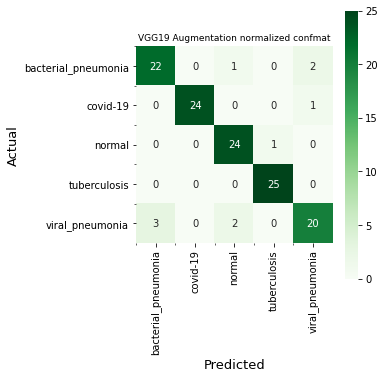

In [ ]:
del model
model = load_model('VGG19 Augmentation normalized.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))
plot_confusion_matrix('VGG19 Augmentation normalized confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


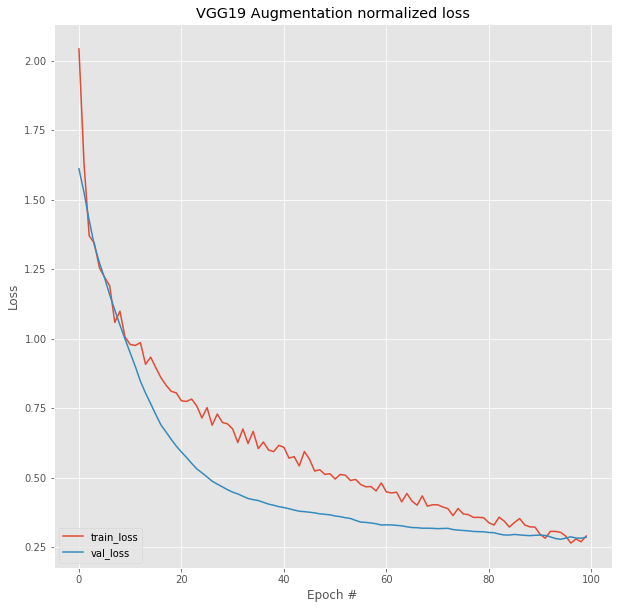

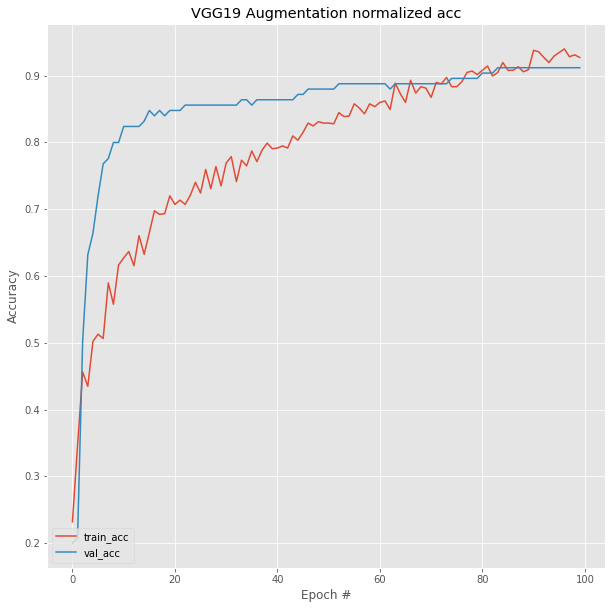

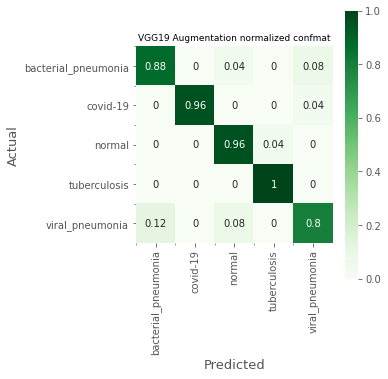

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 Augmentation normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 Augmentation normalized acc')
plot_confusion_matrix('VGG19 Augmentation normalized confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


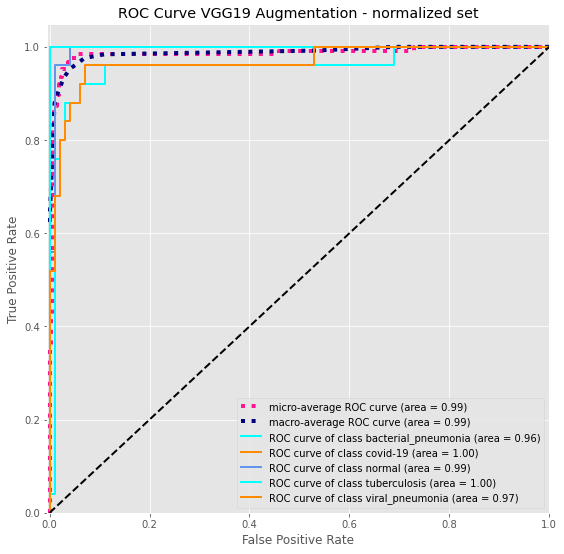

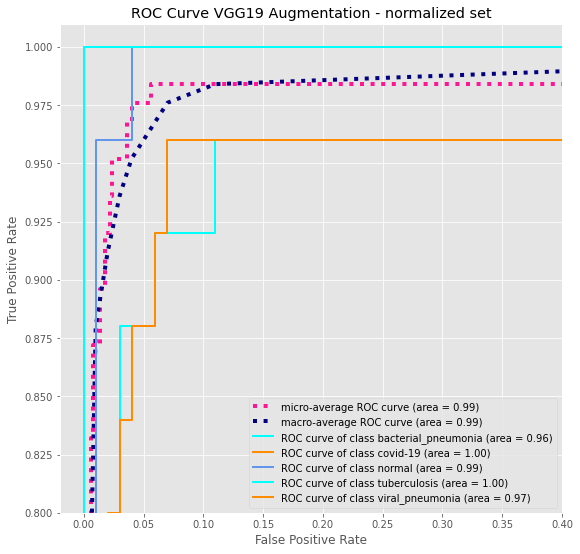

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 Augmentation - normalized set')

#FineTuning

**FineTuning VGG19 after data normalization 0-1**

In [ ]:
model = load_model('VGG19 Augmentation normalized.h5')

In [ ]:
for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

In [ ]:
print(model.name)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 Augmentation normalized.h5', verbose=1
                             ,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode='nearest'
                             )
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_ft, Y_val_ft))

In [ ]:
del model
model = load_model('FineTuned VGG19 Augmentation normalized.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 28s 7s/step - loss: 0.2356 - accuracy: 0.9200
Final Loss: 0.2355651557445526, Final Accuracy: 0.9200000166893005
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.88      0.86        25
           covid-19       1.00      0.96      0.98        25
             normal       0.92      0.96      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


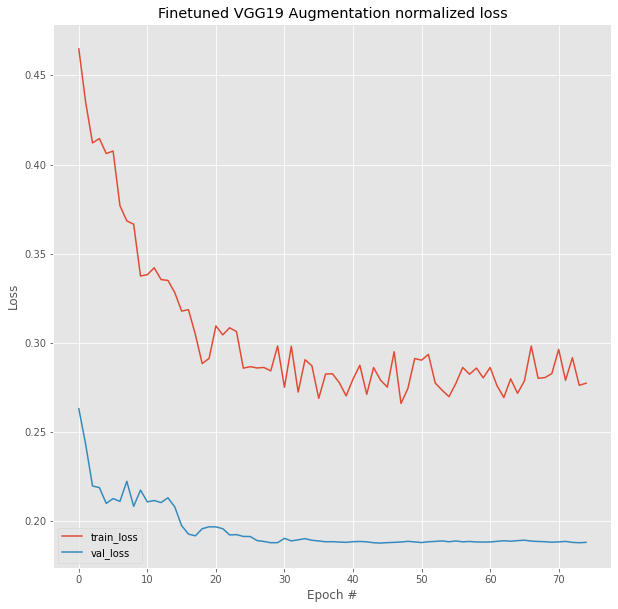

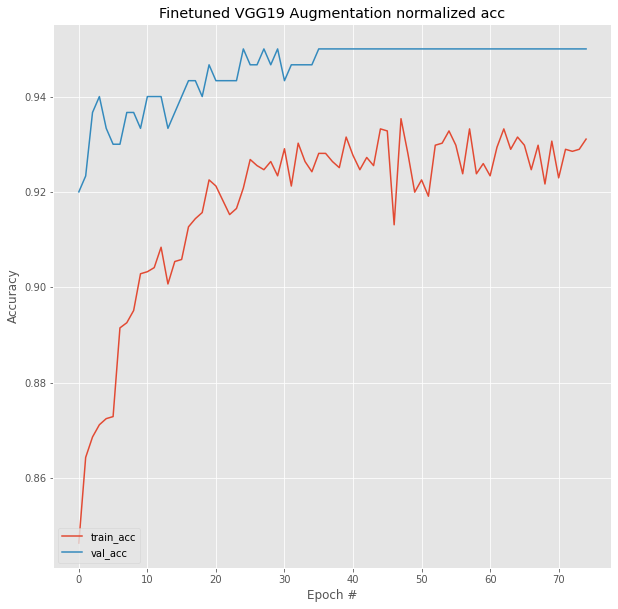

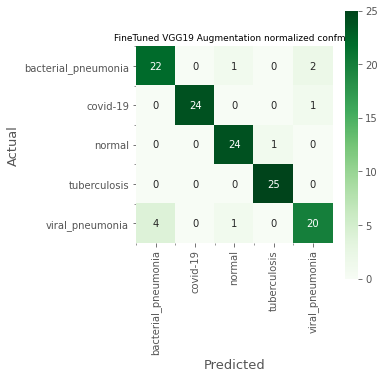

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned VGG19 Augmentation normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned VGG19 Augmentation normalized acc')
plot_confusion_matrix('FineTuned VGG19 Augmentation normalized confmat',Y_true, Y_pred, categories, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


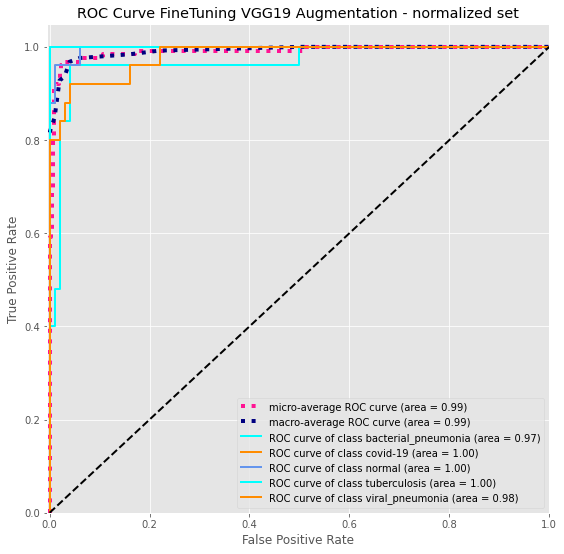

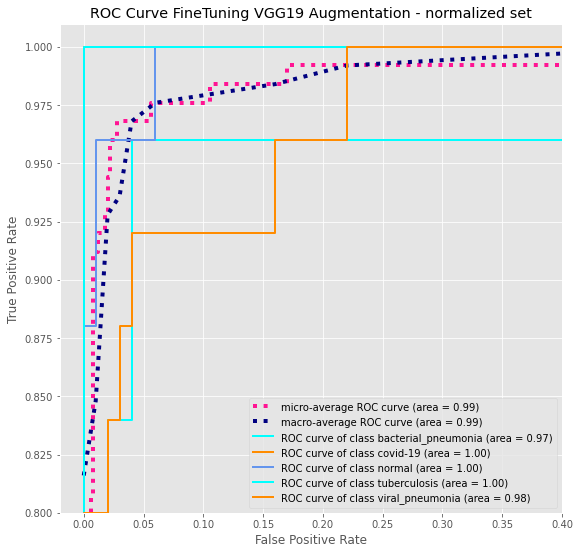

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 Augmentation - normalized set')

# AUGMENTATION on data divided by 255 + CLAHE processed

**Transfer learning after CLAHE processing imgs**

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 Augmentation CLAHE.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 95s 3s/step - loss: 2.1533 - accuracy: 0.2194 - val_loss: 1.5344 - val_accuracy: 0.4640

Epoch 00001: val_loss improved from inf to 1.53439, saving model to VGG19 Augmentation CLAHE.h5
Epoch 2/100
15/15 [==============================] - 15s 969ms/step - loss: 1.6949 - accuracy: 0.3482 - val_loss: 1.3855 - val_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.53439 to 1.38553, saving model to VGG19 Augmentation CLAHE.h5
Epoch 3/100
15/15 [==============================] - 15s 964ms/step - loss: 1.4260 - accuracy: 0.4259 - val_loss: 1.2741 - val_accuracy: 0.4480

Epoch 00003: val_loss improved from 1.38553 to 1.27406, saving model to VGG19 Augmentation CLAHE.h5
Epoch 4/100
15/15 [==============================] - 15s 968ms/step - loss: 1.3431 - accuracy: 0.4693 - val_loss: 1.1977 - val_accuracy: 0.5760

Epoch 00004: val_loss improved from 1.27406 to 1.19768, saving model to VGG19 Augmentation CLAHE.h5
Epoch 5/100
15/15 [========

4/4 [==============================] - 5s 1s/step - loss: 0.3430 - accuracy: 0.8880
Final Loss: 0.34299585223197937, Final Accuracy: 0.8880000114440918
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       1.00      1.00      1.00        25
             normal       0.77      0.96      0.86        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.94      0.64      0.76        25

           accuracy                           0.89       125
          macro avg       0.90      0.89      0.88       125
       weighted avg       0.90      0.89      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


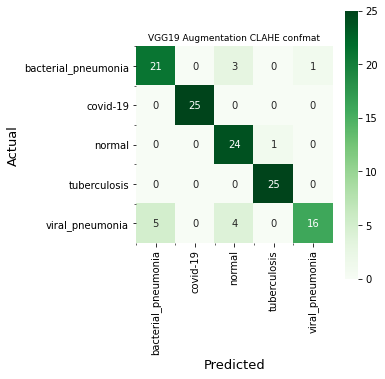

In [ ]:
del model
model = load_model('VGG19 Augmentation CLAHE.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

plot_confusion_matrix('VGG19 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


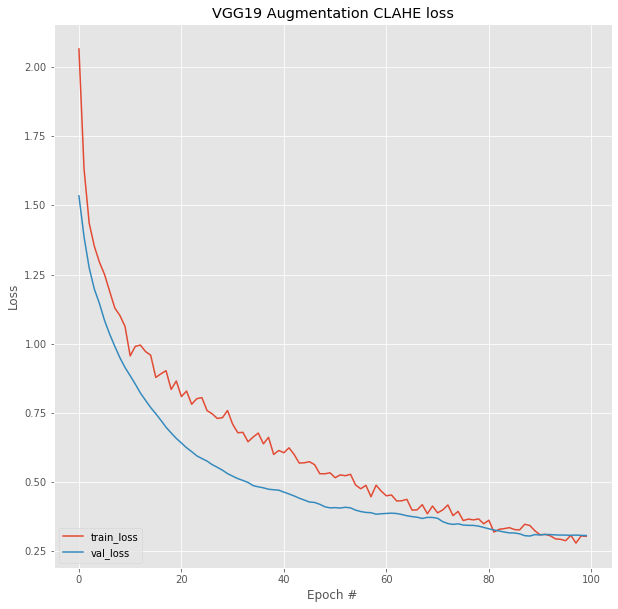

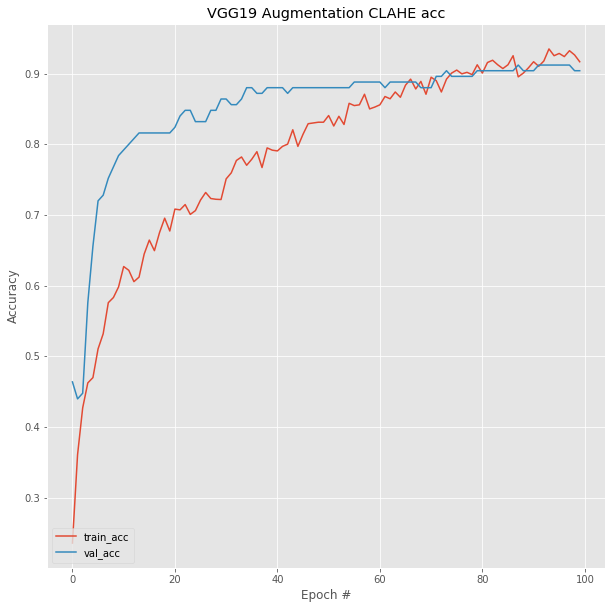

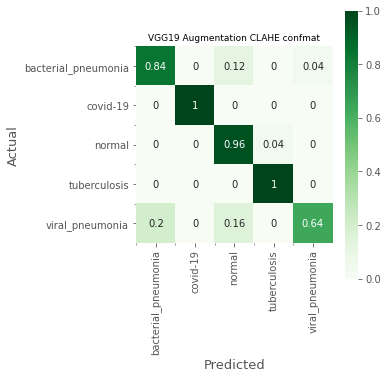

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 Augmentation CLAHE loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 Augmentation CLAHE acc')
plot_confusion_matrix('VGG19 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


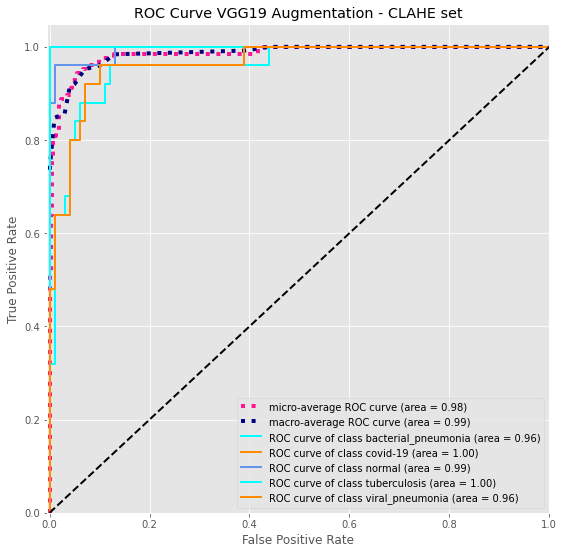

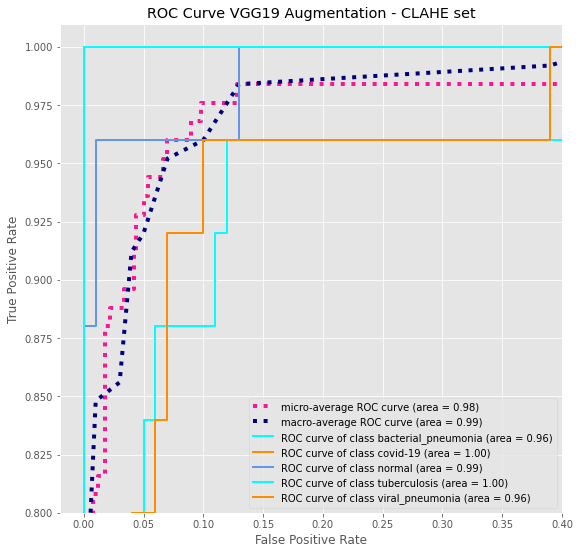

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 Augmentation - CLAHE set')

#FineTuning

**FineTuning VGG19 on CLAHE processed imgs**

In [ ]:
del model
model = load_model('VGG19 Augmentation CLAHE.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(learning_rate= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 Augmentation CLAHE.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE_ft, Y_val_ft))

Epoch 1/100
37/37 [==============================] - 43s 1s/step - loss: 0.5022 - accuracy: 0.8326 - val_loss: 0.2499 - val_accuracy: 0.9267

Epoch 00001: val_loss improved from inf to 0.24989, saving model to FineTuned VGG19 Augmentation CLAHE.h5
Epoch 2/100
37/37 [==============================] - 37s 979ms/step - loss: 0.4793 - accuracy: 0.8579 - val_loss: 0.2457 - val_accuracy: 0.9400

Epoch 00002: val_loss improved from 0.24989 to 0.24572, saving model to FineTuned VGG19 Augmentation CLAHE.h5
Epoch 3/100
37/37 [==============================] - 37s 997ms/step - loss: 0.4704 - accuracy: 0.8652 - val_loss: 0.2375 - val_accuracy: 0.9300

Epoch 00003: val_loss improved from 0.24572 to 0.23754, saving model to FineTuned VGG19 Augmentation CLAHE.h5
Epoch 4/100
37/37 [==============================] - 37s 991ms/step - loss: 0.4317 - accuracy: 0.8682 - val_loss: 0.2415 - val_accuracy: 0.9333

Epoch 00004: val_loss did not improve from 0.23754
Epoch 5/100
37/37 [===========================

In [ ]:
del model
model = load_model('FineTuned VGG19 Augmentation CLAHE.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 26s 6s/step - loss: 0.2926 - accuracy: 0.8960
Final Loss: 0.2926386594772339, Final Accuracy: 0.8960000276565552
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       1.00      1.00      1.00        25
             normal       0.80      0.96      0.87        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.90      0.72      0.80        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.89       125
       weighted avg       0.90      0.90      0.89       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


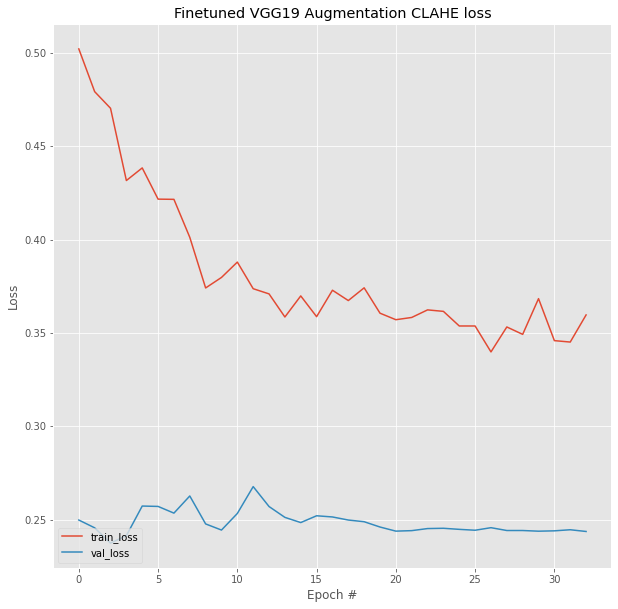

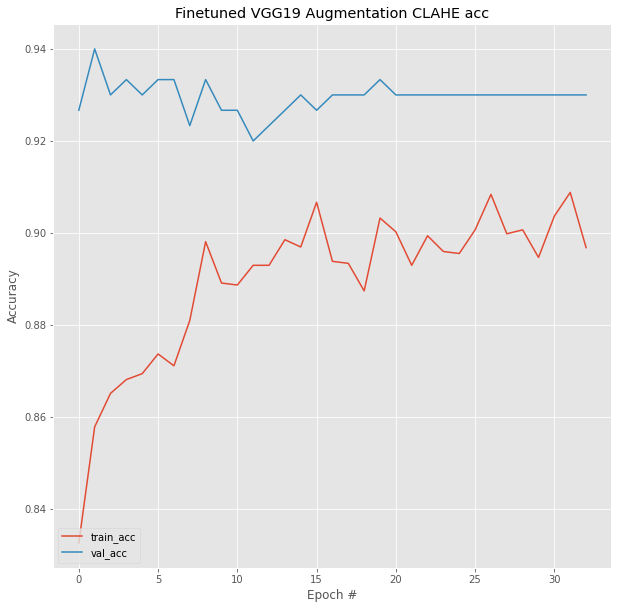

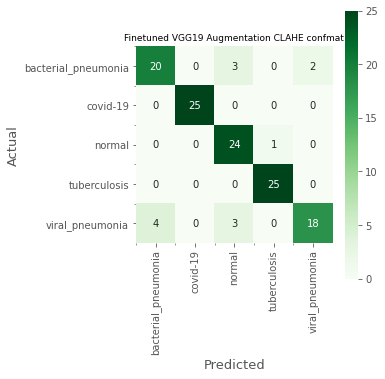

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned VGG19 Augmentation CLAHE loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned VGG19 Augmentation CLAHE acc')
plot_confusion_matrix('Finetuned VGG19 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


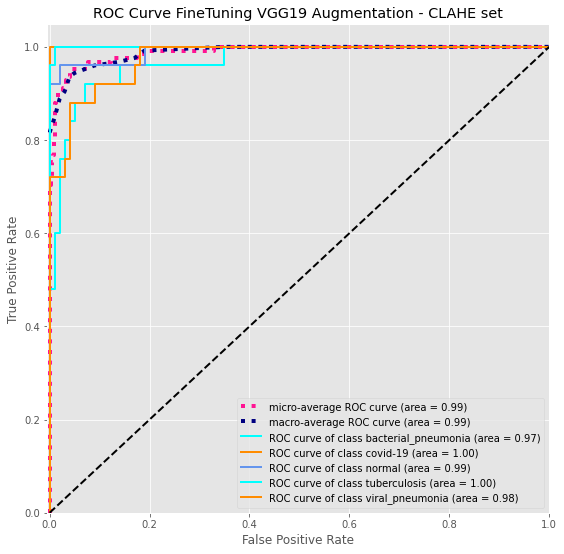

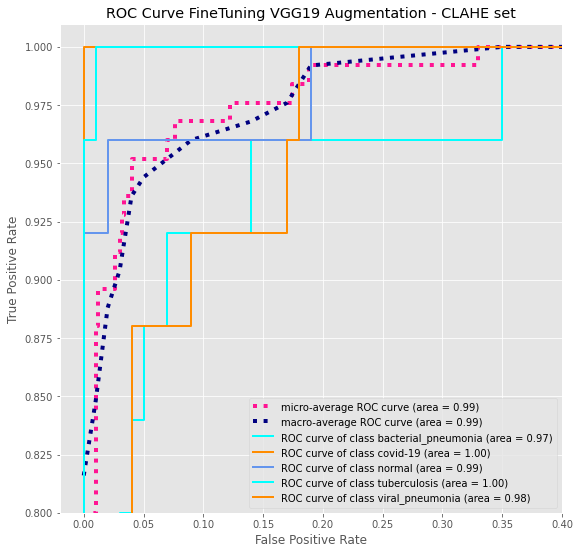

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 Augmentation - CLAHE set')

# AUGMENTATION on data normalized to (0-1) + CLAHE processed

**Transfer learning after CLAHE processing imgs**

In [ ]:
del model
model = build_ImageNetModel(VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: False
layer 18: block5_conv2, trainable: False
layer 19: block5_conv3, trainable: False
layer 20: block5_conv4, trainable: False
layer 21: block5_pool, trainable: False
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
lay

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('VGG19 Augmentation CLAHE + normalized.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 17s 974ms/step - loss: 2.1625 - accuracy: 0.2154 - val_loss: 1.4806 - val_accuracy: 0.4640

Epoch 00001: val_loss improved from inf to 1.48062, saving model to VGG19 Augmentation CLAHE + normalized.h5
Epoch 2/100
15/15 [==============================] - 15s 963ms/step - loss: 1.6810 - accuracy: 0.3489 - val_loss: 1.3691 - val_accuracy: 0.6240

Epoch 00002: val_loss improved from 1.48062 to 1.36909, saving model to VGG19 Augmentation CLAHE + normalized.h5
Epoch 3/100
15/15 [==============================] - 15s 955ms/step - loss: 1.5062 - accuracy: 0.3982 - val_loss: 1.2977 - val_accuracy: 0.6160

Epoch 00003: val_loss improved from 1.36909 to 1.29766, saving model to VGG19 Augmentation CLAHE + normalized.h5
Epoch 4/100
15/15 [==============================] - 15s 954ms/step - loss: 1.3758 - accuracy: 0.4452 - val_loss: 1.2354 - val_accuracy: 0.6240

Epoch 00004: val_loss improved from 1.29766 to 1.23539, saving model to VGG19 Augment

4/4 [==============================] - 5s 1s/step - loss: 0.3364 - accuracy: 0.8880
Final Loss: 0.3364386558532715, Final Accuracy: 0.8880000114440918
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.77      0.80      0.78        25
           covid-19       1.00      1.00      1.00        25
             normal       0.83      0.96      0.89        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.89      0.68      0.77        25

           accuracy                           0.89       125
          macro avg       0.89      0.89      0.89       125
       weighted avg       0.89      0.89      0.89       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


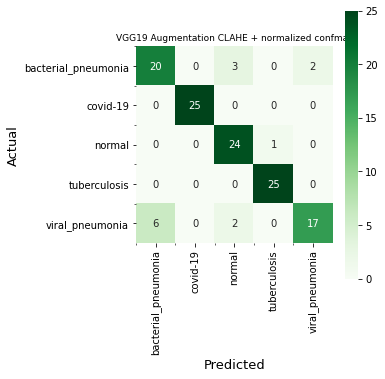

In [ ]:
del model
model = load_model('VGG19 Augmentation CLAHE + normalized.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

plot_confusion_matrix('VGG19 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


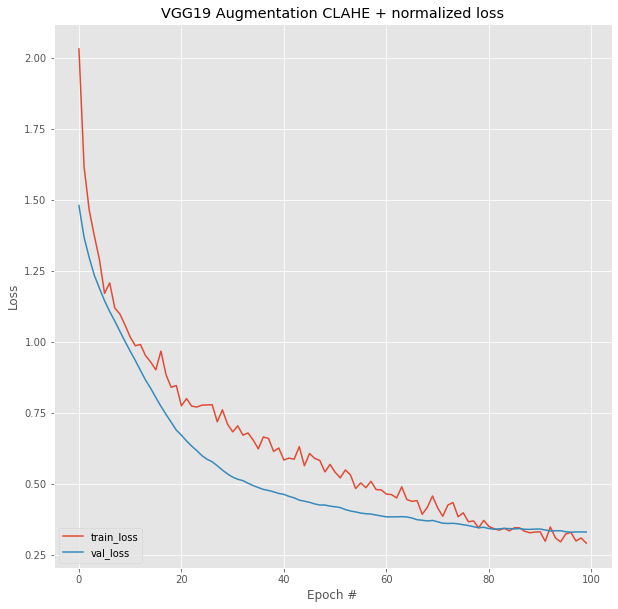

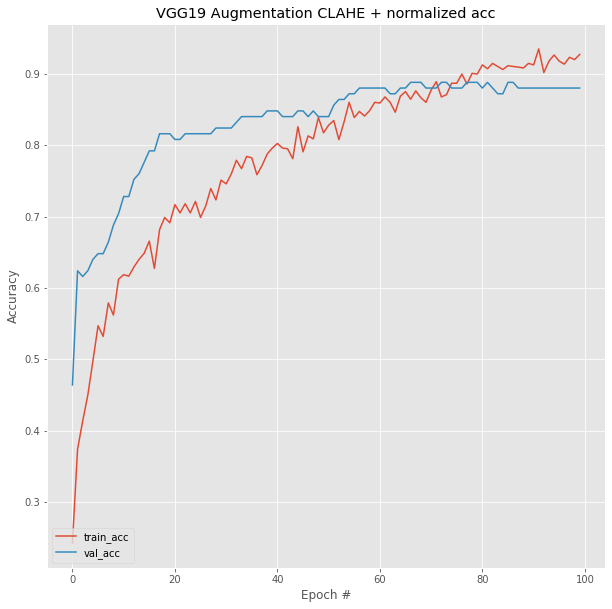

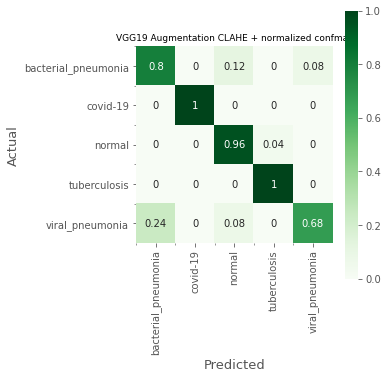

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'VGG19 Augmentation CLAHE + normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'VGG19 Augmentation CLAHE + normalized acc')
plot_confusion_matrix('VGG19 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


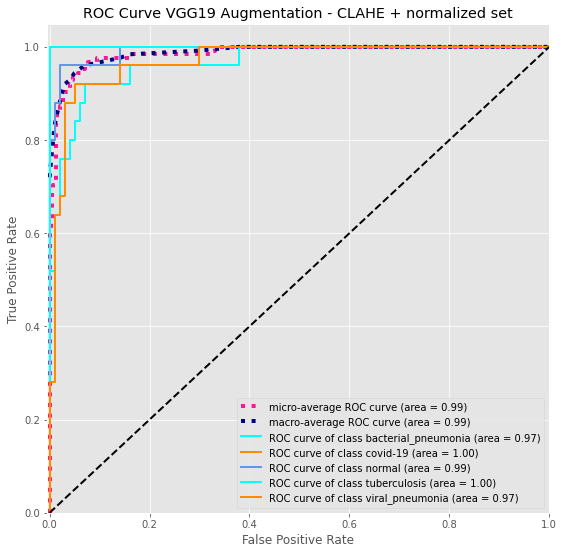

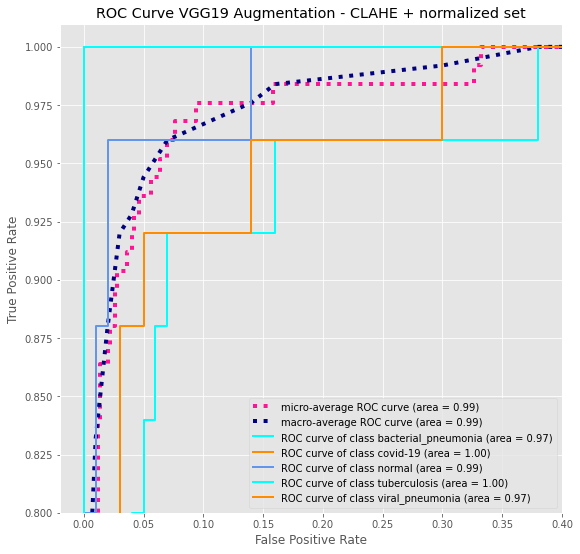

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve VGG19 Augmentation - CLAHE + normalized set')

#FineTuning

**FineTuning VGG19 on CLAHE processed imgs**

In [ ]:
del model
model = load_model('VGG19 Augmentation CLAHE + normalized.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-17:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_conv4, trainable: False
layer 11: block3_pool, trainable: False
layer 12: block4_conv1, trainable: False
layer 13: block4_conv2, trainable: False
layer 14: block4_conv3, trainable: False
layer 15: block4_conv4, trainable: False
layer 16: block4_pool, trainable: False
layer 17: block5_conv1, trainable: True
layer 18: block5_conv2, trainable: True
layer 19: block5_conv3, trainable: True
layer 20: block5_conv4, trainable: True
layer 21: block5_pool, trainable: True
layer 22: flatten, trainable: True
layer 23: batch_normalization, trainable: True
layer 24: dense, trainable: True
layer 25

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(X_train_CLAHE_ft.shape)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned VGG19 Augmentation CLAHE + normalized.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE_ft, Y_val_ft))

(2400, 224, 224, 3)
Epoch 1/100
37/37 [==============================] - 29s 742ms/step - loss: 0.4669 - accuracy: 0.8532 - val_loss: 0.2606 - val_accuracy: 0.9200

Epoch 00001: val_loss improved from inf to 0.26065, saving model to FineTuned VGG19 Augmentation CLAHE + normalized.h5
Epoch 2/100
37/37 [==============================] - 25s 677ms/step - loss: 0.4609 - accuracy: 0.8587 - val_loss: 0.2376 - val_accuracy: 0.9400

Epoch 00002: val_loss improved from 0.26065 to 0.23764, saving model to FineTuned VGG19 Augmentation CLAHE + normalized.h5
Epoch 3/100
37/37 [==============================] - 25s 678ms/step - loss: 0.4607 - accuracy: 0.8579 - val_loss: 0.2433 - val_accuracy: 0.9300

Epoch 00003: val_loss did not improve from 0.23764
Epoch 4/100
37/37 [==============================] - 25s 675ms/step - loss: 0.4259 - accuracy: 0.8669 - val_loss: 0.2331 - val_accuracy: 0.9367

Epoch 00004: val_loss improved from 0.23764 to 0.23308, saving model to FineTuned VGG19 Augmentation CLAHE 

In [ ]:
del model
model = load_model('FineTuned VGG19 Augmentation CLAHE + normalized.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 26s 6s/step - loss: 0.2434 - accuracy: 0.9280
Final Loss: 0.24337992072105408, Final Accuracy: 0.9279999732971191
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.84      0.84      0.84        25
           covid-19       1.00      1.00      1.00        25
             normal       0.89      0.96      0.92        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.95      0.84      0.89        25

           accuracy                           0.93       125
          macro avg       0.93      0.93      0.93       125
       weighted avg       0.93      0.93      0.93       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


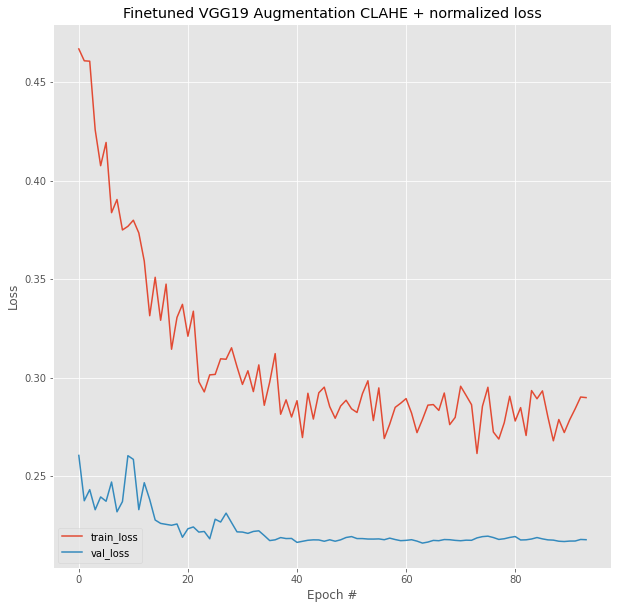

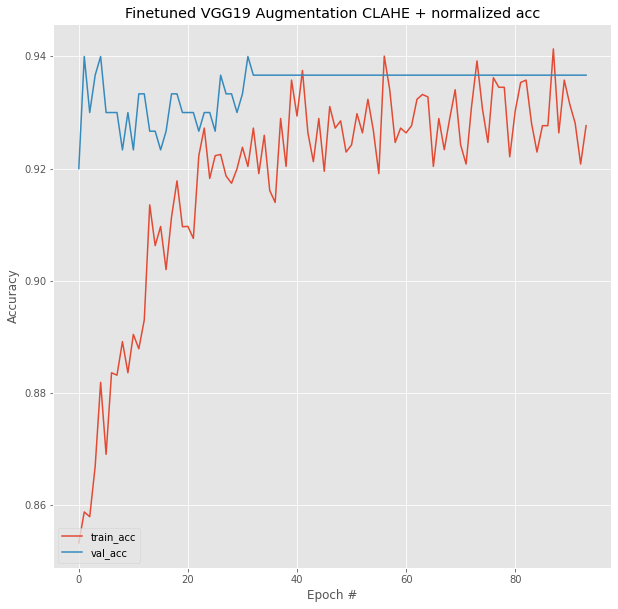

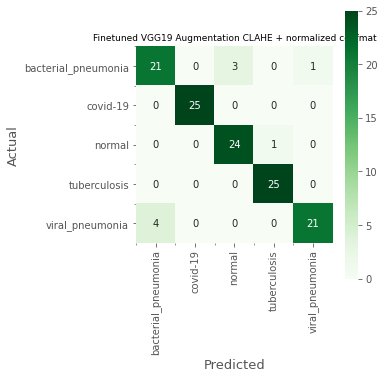

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned VGG19 Augmentation CLAHE + normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned VGG19 Augmentation CLAHE + normalized acc')
plot_confusion_matrix('Finetuned VGG19 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


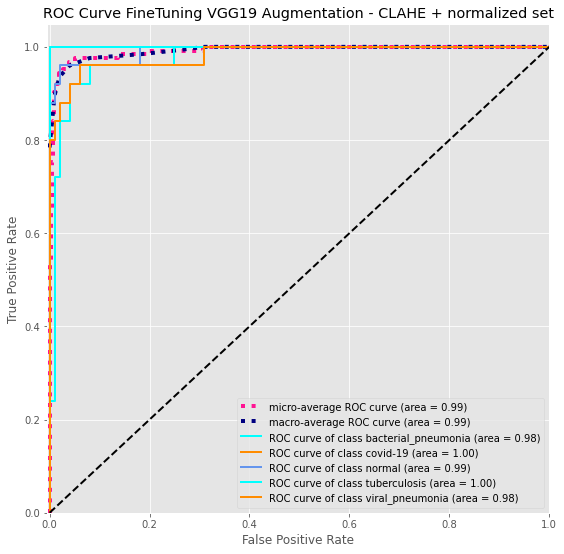

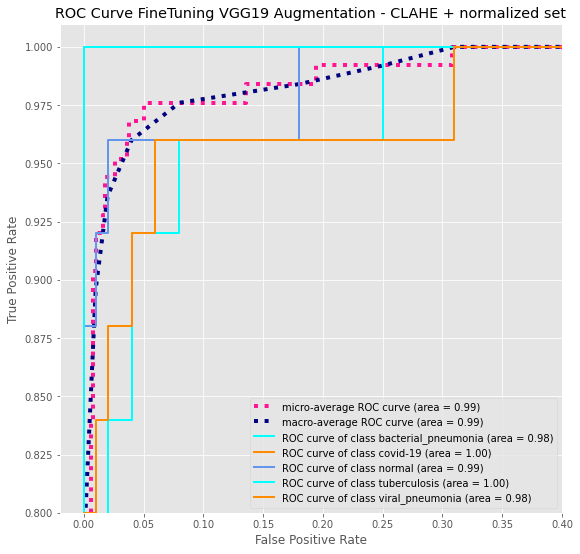

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning VGG19 Augmentation - CLAHE + normalized set')

# Defining and loading Functions for SVM

In [ ]:
pip install daal4py

In [ ]:
import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [ ]:
from daal4py.sklearn import patch_sklearn
patch_sklearn()

dispatcher.py:151: FutureWarning: 
Scikit-learn patching with daal4py is deprecated and will be removed in the future.
Use Intel(R) Extension for Scikit-learn* module instead (pip install scikit-learn-intelex).
To enable patching, please use one of the following options:
1) From the command line:
    python -m sklearnex <your_script>
2) From your script:
    from sklearnex import patch_sklearn
    patch_sklearn()
Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1, 7)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
def make_classification(svc, confmat_title, ROC_title, training_title, X_train, y_train, X_test, y_test, cv, kernel, decision_function_shape, verbose, C, with_grid_search, normalize, y_test_ROC):
  from sklearn.metrics import classification_report
  if with_grid_search==True:
    print('Training with parameter GridSearch tuning')
    param = {
      "C": C,
      "kernel": [kernel],
      "decision_function_shape":[decision_function_shape]
    }
    # GridSearchCV for hyperparameters optimization
    clf = GridSearchCV(svc, param, cv=cv, verbose = verbose)
    clf.fit(X_train, y_train)
    print("Best params: ",clf.best_params_)
    print("Best estimator: ", clf.best_estimator_)
    clf = clf.best_estimator_
    y_pred = clf.predict(X_test)
    preds=clf.decision_function(X_test)
    print(classification_report(y_test, y_pred, target_names=categories))
    labels = np.unique(y_test)
    print('Loss:', hinge_loss(y_test, preds, labels=labels))
    plot_confusion_matrix(confmat_title, y_test, y_pred, classes = categories, normalize= normalize)
    plt.show()
    plot_ROC_SVM(X_train, y_train, X_test, y_test, preds, len(categories), categories, ROC_title, cv)

    plot_learning_curve(clf, title=training_title, X=X_train, y=y_train, cv=cv)

    return clf
  elif with_grid_search==False:
    print('Training without parameter tuning')
    svc = SVC(verbose = verbose)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print(y_pred.shape)
    print(classification_report(y_test, y_pred, target_names=categories))
    plot_confusion_matrix(confmat_title, y_test, y_pred, classes = categories, normalize= normalize)
    plt.show()
    plot_ROC_SVM(X_train, y_train, X_test, y_test, svc, len(categories), categories, ROC_title, cv)
    plot_learning_curve(svc, title=training_title, X=X_train, y=y_train, cv=cv)
    return svc
  

# Feature Extraction and SVM CLASSIFICATION on data divided by 255

**USING SVM CLASSIFIER**

**ImageData / 255**

In [ ]:
base_model = (VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]
output_shape

512

In [ ]:
train_features = base_model.predict(X_train_255)
val_features = base_model.predict(X_val_255)
test_features = base_model.predict(X_test_255)

In [ ]:
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
print(train_features.shape)

(1000, 7, 7, 512)
(1000, 25088)


In [ ]:
print(val_features.shape)
val_features = val_features.reshape(val_features.shape[0],val_features.shape[1]*val_features.shape[2]*val_features.shape[3])
print(val_features.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
print(test_features.shape)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2]*test_features.shape[3])
print(test_features.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
print(Y_train.shape)
train_labels = train['Disease Type'].values
test_labels = test['Disease Type'].values
val_labels = val['Disease Type'].values
print(val_labels.shape)

(1000, 5)
(125,)


In [ ]:
train_val_concat_features = np.concatenate((train_features, val_features))
train_val_concat_labels = np.concatenate((train_labels, val_labels))

In [ ]:
print(Y_test.shape)
print(test_labels.shape)

(125, 5)
(125,)


Train with Grid Search

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.689, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.844, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.787, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.738, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.813, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.689, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.844, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.787, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best params:  {'C': 0.004124626382901352, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.76      0.88      0.81        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      0.96      0.91        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.95      0.72      0.82        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125

Loss: 0.20376552509428708
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


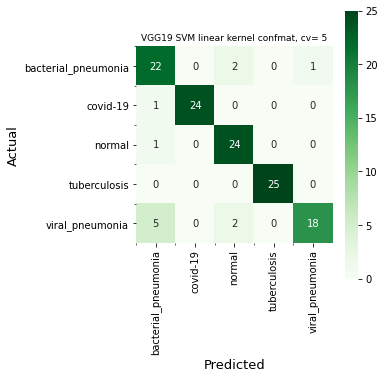

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


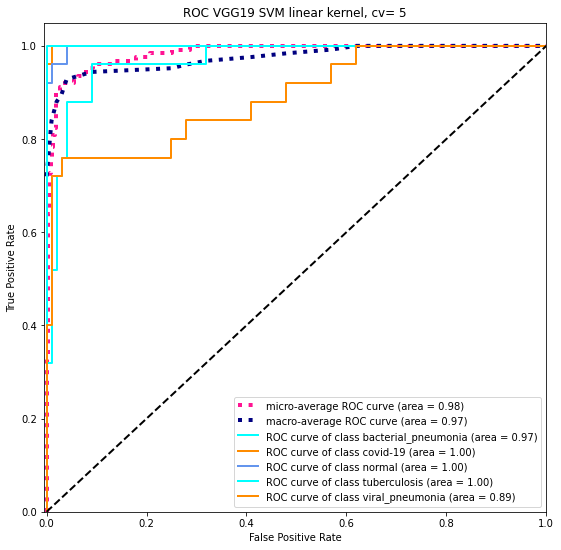

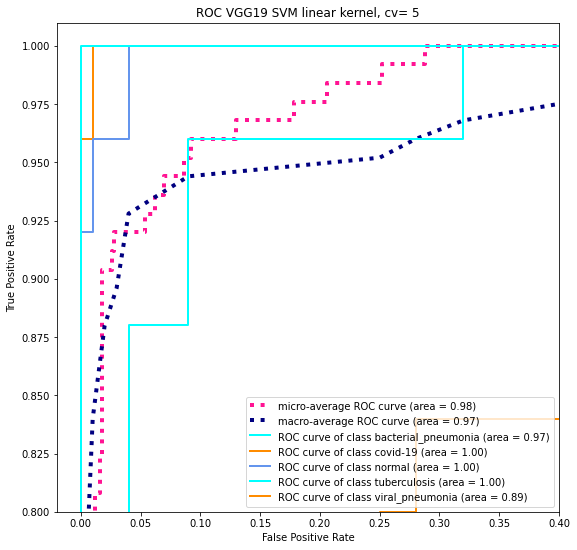

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

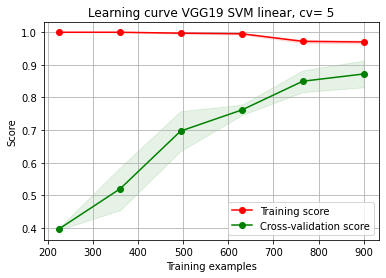

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
svm = make_classification(SVC(), 'VGG19 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.539, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.676, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.637, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.619, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.539, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.676, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.637, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.619, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.8min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.88      0.85        25
           covid-19       1.00      0.96      0.98        25
             normal       0.83      1.00      0.91        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.95      0.72      0.82        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.1878679715636153
Confusion matrix, without norma

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


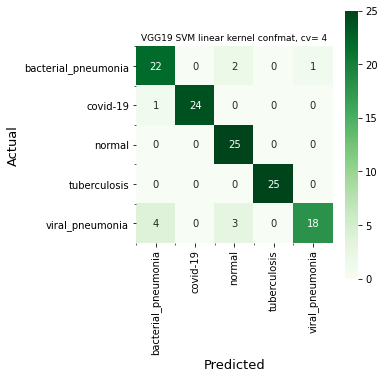

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


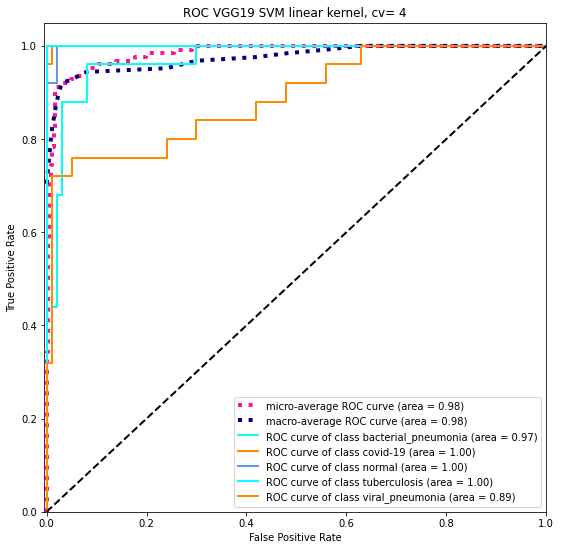

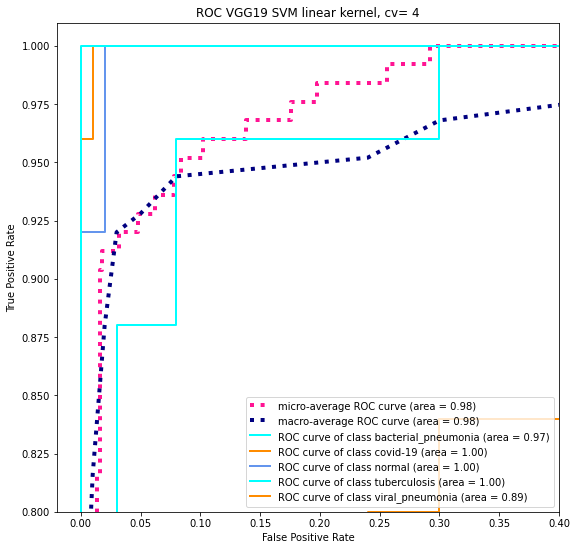

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

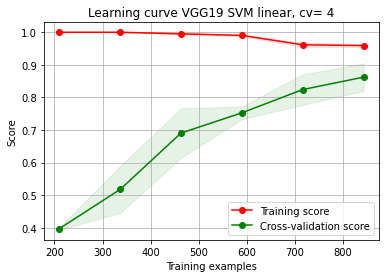

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
svm_2 = make_classification(SVC(), 'VGG19 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.755, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.784, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.787, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.755, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.784, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.787, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.755, total=   0.8s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.784, total=   0.7s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.3min finished


Best params:  {'C': 0.002030917620904737, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.88      0.86        25
           covid-19       1.00      1.00      1.00        25
             normal       0.81      1.00      0.89        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.94      0.68      0.79        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.19625451307935277
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


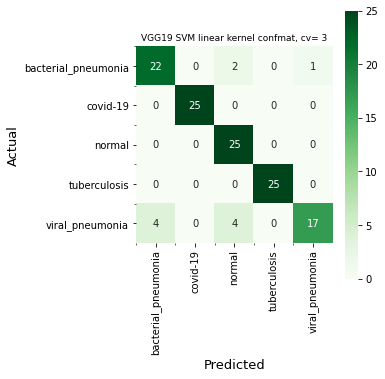

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


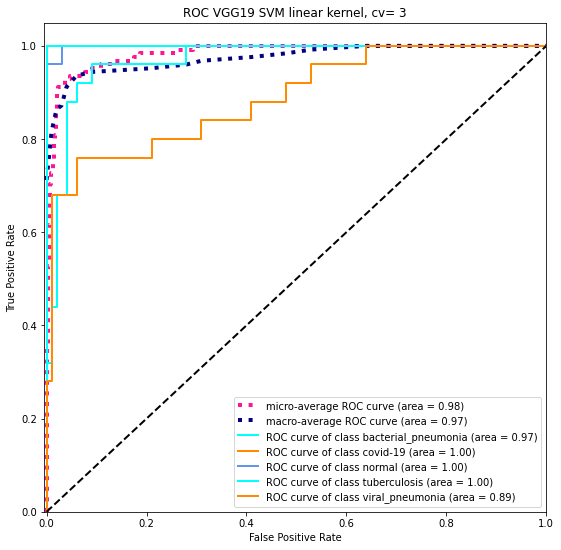

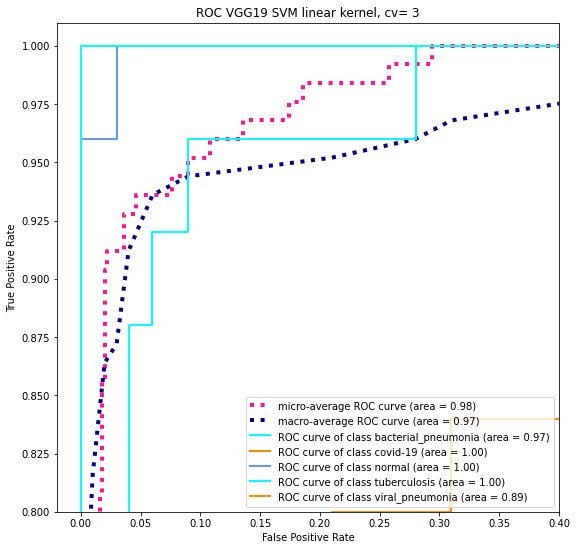

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


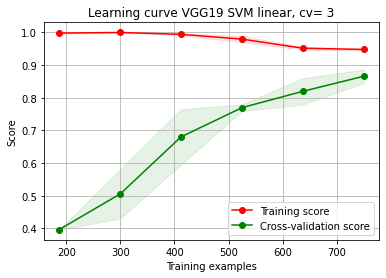

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
svm_3 = make_classification(SVC(), 'VGG19 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data normalized to (0-1)

In [ ]:
del base_model
base_model = (VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))# Freezing layers in convolutional base
base_model.trainable = False

# A look at the base model architecture
base_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

512


In [ ]:
del train_features, val_features, test_features
train_features = base_model.predict(X_train)
val_features = base_model.predict(X_val)
test_features = base_model.predict(X_test)

In [ ]:
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
print(train_features.shape)

(1000, 7, 7, 512)
(1000, 25088)


In [ ]:
print(val_features.shape)
val_features = val_features.reshape(val_features.shape[0], val_features.shape[1]*val_features.shape[2]*val_features.shape[3])
print(val_features.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
print(test_features.shape)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2]*test_features.shape[3])
print(test_features.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
del train_labels, test_labels, val_labels
print(Y_train.shape)
train_labels = train['Disease Type'].values
test_labels = test['Disease Type'].values
val_labels = val['Disease Type'].values
print(val_labels.shape)

(1000, 5)
(125,)


In [ ]:
train_val_concat_features = np.concatenate((train_features, val_features))

In [ ]:
train_val_concat_labels = np.concatenate((train_labels, val_labels))

In [ ]:
train_val_concat_features.shape
train_val_concat_labels.shape
np.unique(train_val_concat_labels).shape

Train with Grid Search

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.702, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.831, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.813, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.760, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.836, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.702, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.831, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.813, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best params:  {'C': 0.004124626382901352, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.76      0.88      0.81        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      0.96      0.91        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.89      0.68      0.77        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.89       125
       weighted avg       0.90      0.90      0.89       125

Loss: 0.2206005107637661
Confusion matrix, without normali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


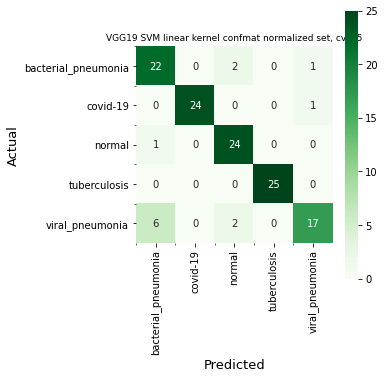

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


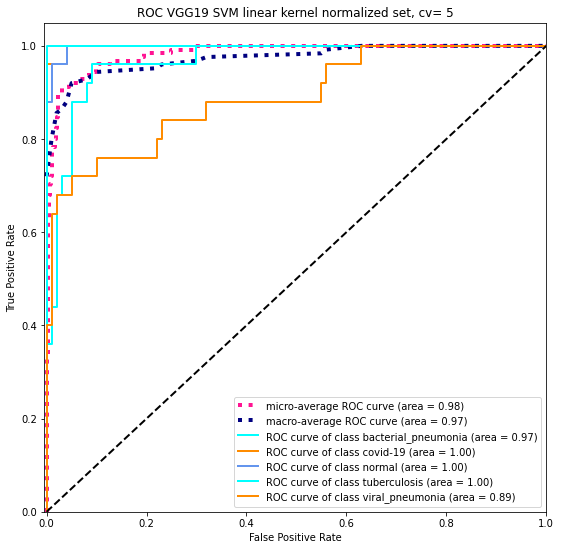

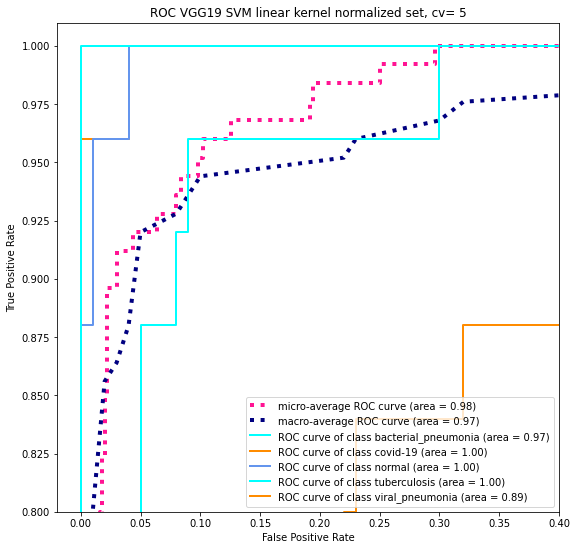

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

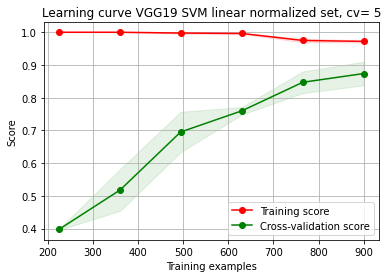

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.543, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.687, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.655, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.633, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.543, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.687, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.655, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.633, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.9min finished


Best params:  {'C': 0.002030917620904737, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.89      0.68      0.77        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125

Loss: 0.20480967007555317
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


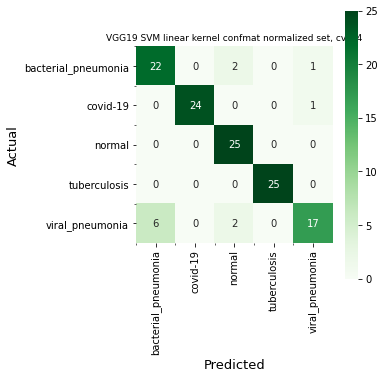

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


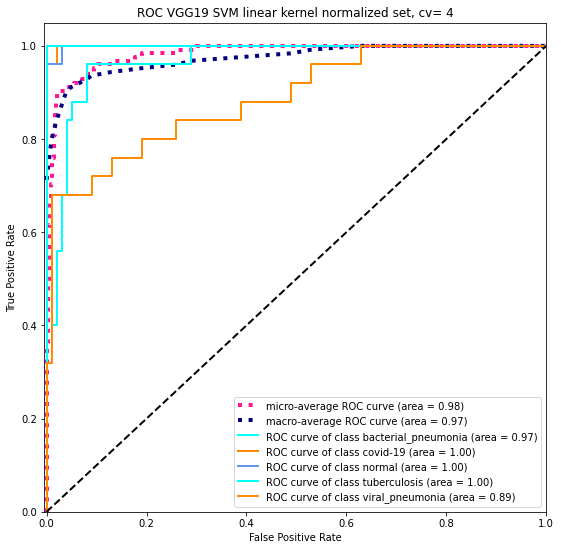

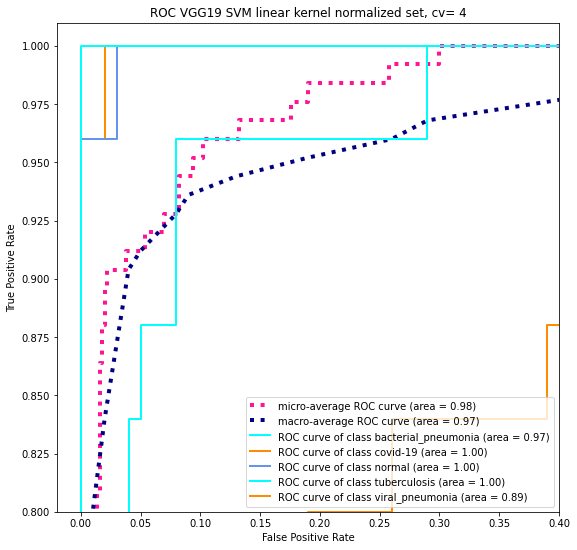

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

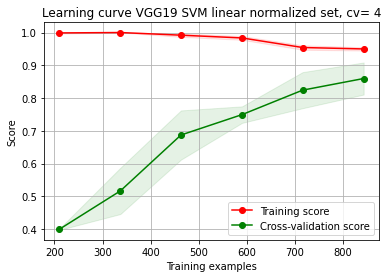

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.749, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.789, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.795, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.749, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.789, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.795, total=   0.8s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.749, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.789, total=   0.8s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


Best params:  {'C': 0.002030917620904737, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.89      0.68      0.77        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125

Loss: 0.20480967007555317
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


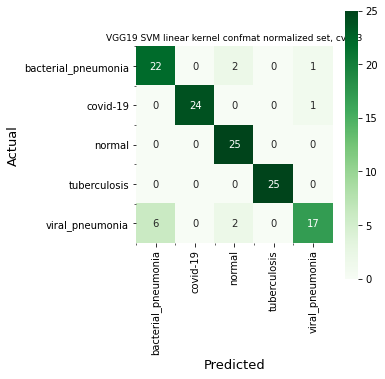

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


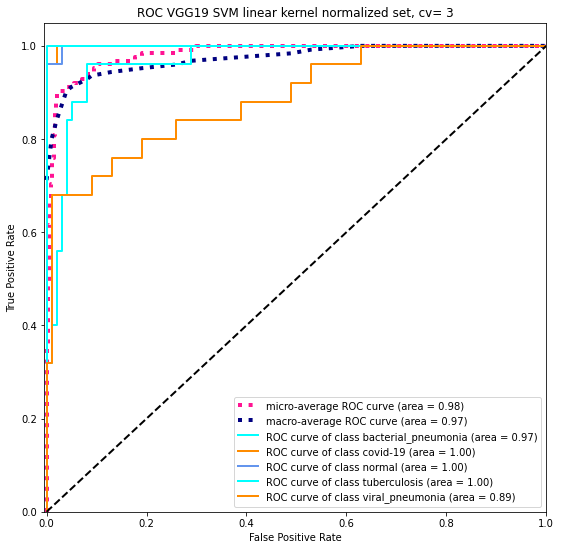

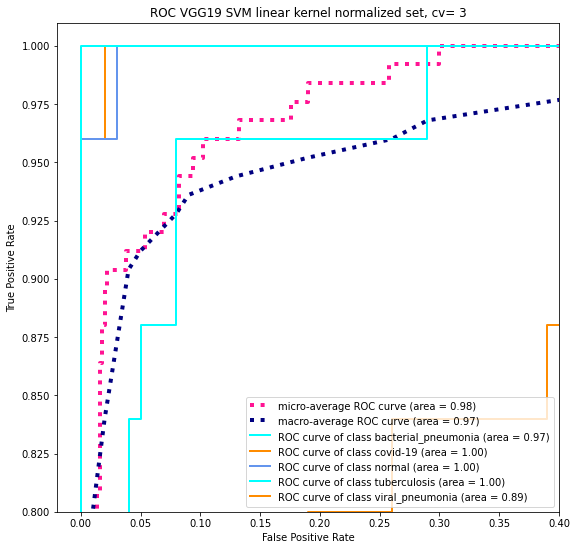

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

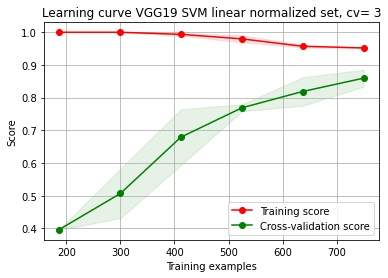

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data divided by 255 + CLAHE processed

In [ ]:
del base_model
base_model = (VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

512


In [ ]:
train_features_CLAHE_ = base_model.predict(X_train_255_CLAHE)
val_features_CLAHE_ = base_model.predict(X_val_255_CLAHE)
test_features_CLAHE_ = base_model.predict(X_test_255_CLAHE)

In [ ]:
print(test_features_CLAHE_.shape)

test_features_CLAHE_ = test_features_CLAHE_.reshape(test_features_CLAHE_.shape[0], test_features_CLAHE_.shape[1]*test_features_CLAHE_.shape[2]*test_features_CLAHE_.shape[3])
print(test_features_CLAHE_.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
print(train_features_CLAHE_.shape)

train_features_CLAHE_ = train_features_CLAHE_.reshape(train_features_CLAHE_.shape[0], train_features_CLAHE_.shape[1]*train_features_CLAHE_.shape[2]*train_features_CLAHE_.shape[3])
print(train_features_CLAHE_.shape)

(1000, 7, 7, 512)
(1000, 25088)


In [ ]:
print(val_features_CLAHE_.shape)

val_features_CLAHE_ = val_features_CLAHE_.reshape(val_features_CLAHE_.shape[0], val_features_CLAHE_.shape[1]*val_features_CLAHE_.shape[2]*val_features_CLAHE_.shape[3])
print(val_features_CLAHE_.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
train_labelsCLAHE_ = train['Disease Type'].values
test_labelsCLAHE_ = test['Disease Type'].values
val_labelsCLAHE_ = val['Disease Type'].values

In [ ]:
train_val_concat_features_CLAHE_ = np.concatenate((train_features_CLAHE_, val_features_CLAHE_))

In [ ]:
train_val_concat_labels_CLAHE_ = np.concatenate((train_labelsCLAHE_, val_labelsCLAHE_))

Train with Grid Search


Training without parameter tuning
[LibSVM]                     precision    recall  f1-score   support

bacterial_pneumonia       0.75      0.84      0.79        25
           covid-19       1.00      1.00      1.00        25
             normal       0.75      0.96      0.84        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       1.00      0.56      0.72        25

           accuracy                           0.87       125
          macro avg       0.89      0.87      0.87       125
       weighted avg       0.89      0.87      0.87       125

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


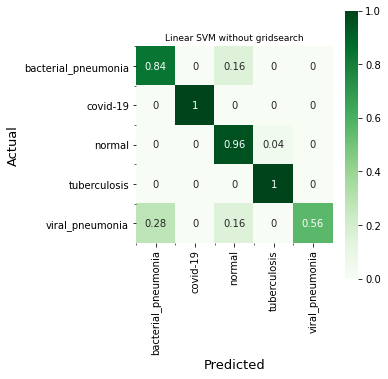

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

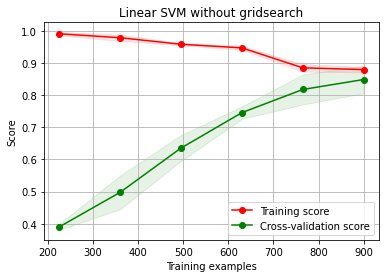

In [ ]:
cv=5
make_classification(SVC(), 'Confmat VGG19 SVM linear kernel without gridsearch', 
                    'ROC VGG19 SVM linear kernel without gridsearch',
                    'Learning curve VGG19 SVM linear kernel without gridsearch',
                    train_val_concat_features, train_val_concat_labels,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    None,  False, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.729, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.867, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.804, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.778, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.831, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.729, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.867, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.804, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best params:  {'C': 0.004124626382901352, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125

Loss: 0.18983966601573699
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


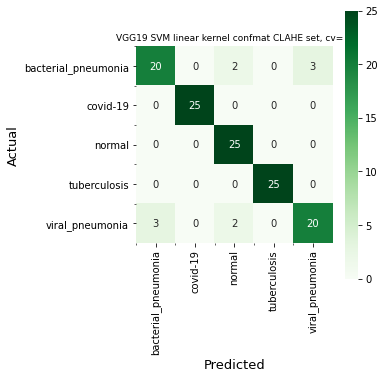

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


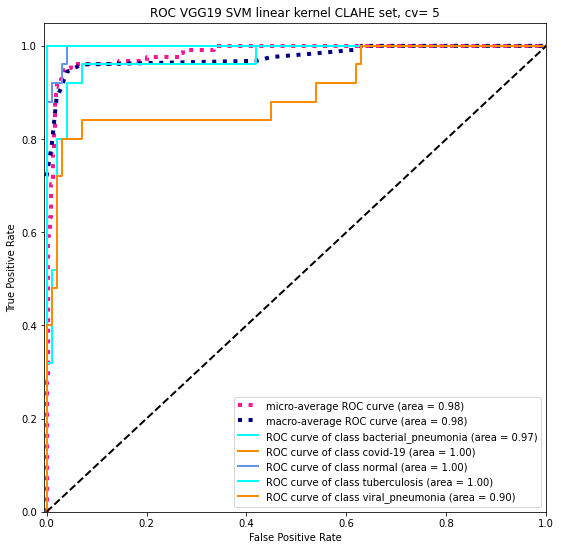

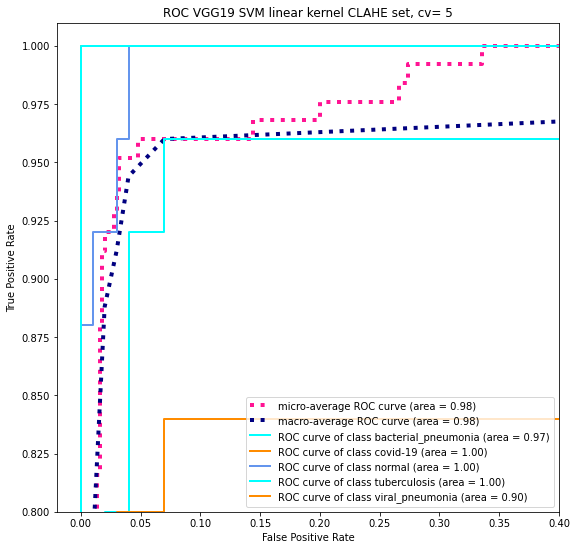

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

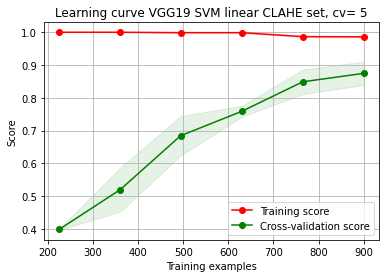

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.550, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.708, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.662, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.665, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.550, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.747, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.662, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.687, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.9min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125

Loss: 0.1890396645921141
Confusion matrix, without norma

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


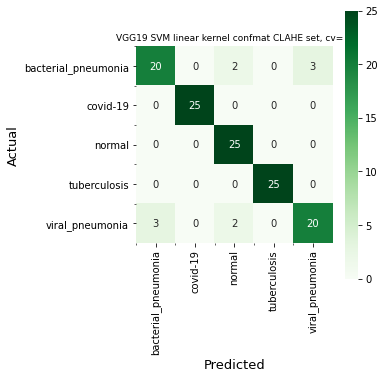

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


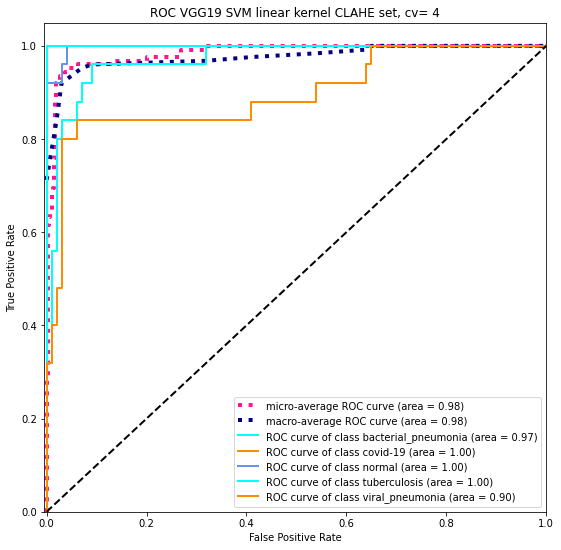

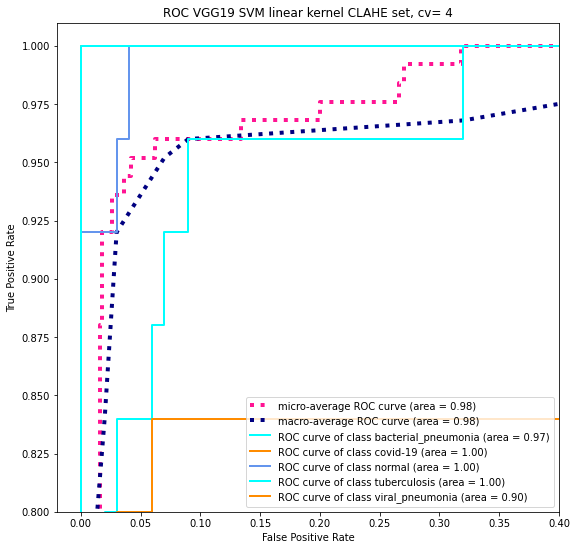

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

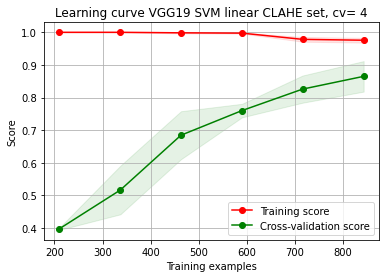

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.779, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.800, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.808, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.779, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.800, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.808, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.779, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.800, total=   0.8s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.3min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125

Loss: 0.1890396645921141
Confusion matrix, without norma

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


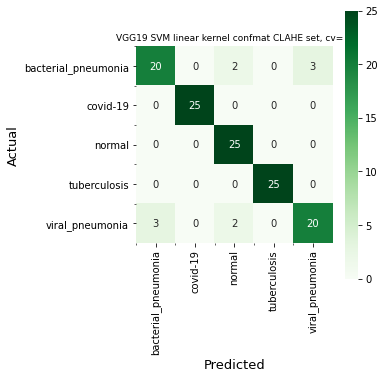

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


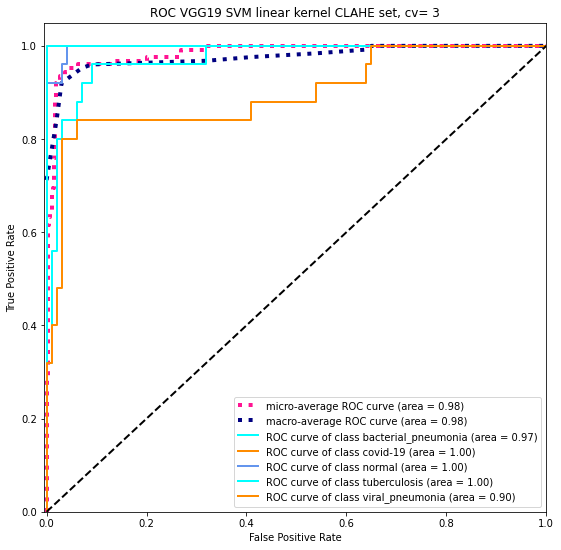

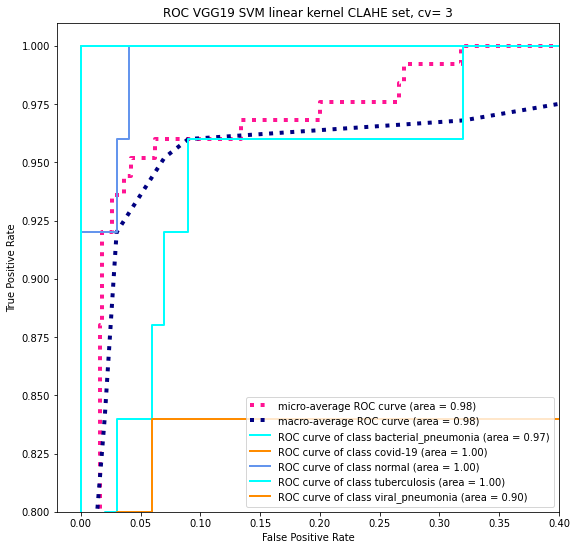

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

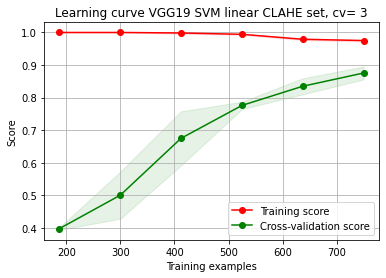

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data normalized to (0-1) + CLAHE processed

In [ ]:
del base_model
base_model = (VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

512


In [ ]:
del train_features_CLAHE_, val_features_CLAHE_, test_features_CLAHE_
train_features_CLAHE_ = base_model.predict(X_train_CLAHE)
val_features_CLAHE_ = base_model.predict(X_val_CLAHE)
test_features_CLAHE_ = base_model.predict(X_test_CLAHE)

In [ ]:
print(test_features_CLAHE_.shape)

test_features_CLAHE_ = test_features_CLAHE_.reshape(test_features_CLAHE_.shape[0], test_features_CLAHE_.shape[1]*test_features_CLAHE_.shape[2]*test_features_CLAHE_.shape[3])
print(test_features_CLAHE_.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
print(train_features_CLAHE_.shape)

train_features_CLAHE_ = train_features_CLAHE_.reshape(train_features_CLAHE_.shape[0], train_features_CLAHE_.shape[1]*train_features_CLAHE_.shape[2]*train_features_CLAHE_.shape[3])
print(train_features_CLAHE_.shape)

(1000, 7, 7, 512)
(1000, 25088)


In [ ]:
print(val_features_CLAHE_.shape)

val_features_CLAHE_ = val_features_CLAHE_.reshape(val_features_CLAHE_.shape[0], val_features_CLAHE_.shape[1]*val_features_CLAHE_.shape[2]*val_features_CLAHE_.shape[3])
print(val_features_CLAHE_.shape)

(125, 7, 7, 512)
(125, 25088)


In [ ]:
train_labelsCLAHE_ = train['Disease Type'].values
test_labelsCLAHE_ = test['Disease Type'].values
val_labelsCLAHE_ = val['Disease Type'].values
print(val_labelsCLAHE_.shape)
print(train_labelsCLAHE_.shape)
print(test_labelsCLAHE_.shape)

(125,)
(1000,)
(125,)


In [ ]:
del train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_
train_val_concat_features_CLAHE_ = np.concatenate((train_features_CLAHE_, val_features_CLAHE_))

In [ ]:
train_val_concat_labels_CLAHE_ = np.concatenate((train_labelsCLAHE_, val_labelsCLAHE_))

Train with Grid Search

Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.738, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.867, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.796, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.778, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.853, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.738, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.867, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.796, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best params:  {'C': 0.004124626382901352, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.88      0.84      0.86        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.91      0.80      0.85        25

           accuracy                           0.93       125
          macro avg       0.93      0.93      0.93       125
       weighted avg       0.93      0.93      0.93       125

Loss: 0.17379557241489696
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


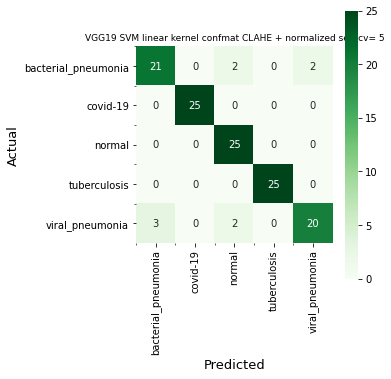

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


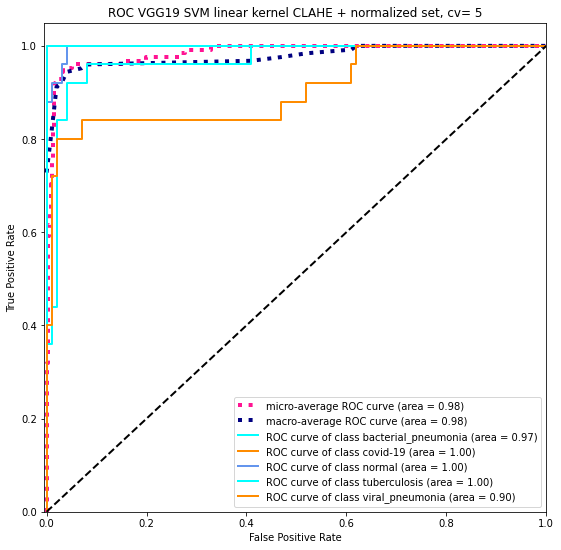

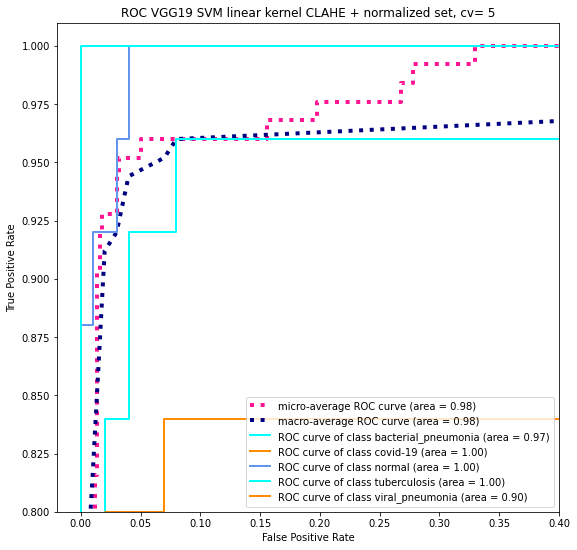

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.004124626382901352, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

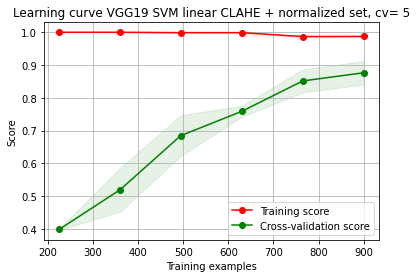

In [ ]:
cv=5
C=np.logspace(-5,1,40)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.553, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.708, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.662, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.665, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.553, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.737, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.662, total=   0.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.694, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.9min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       1.00      1.00      1.00        25
             normal       0.83      1.00      0.91        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.86      0.72      0.78        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.90       125
       weighted avg       0.90      0.90      0.90       125

Loss: 0.22095179020300829
Confusion matrix, without norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


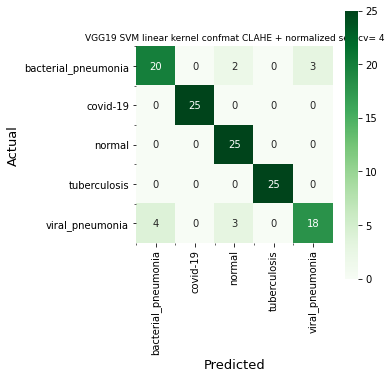

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


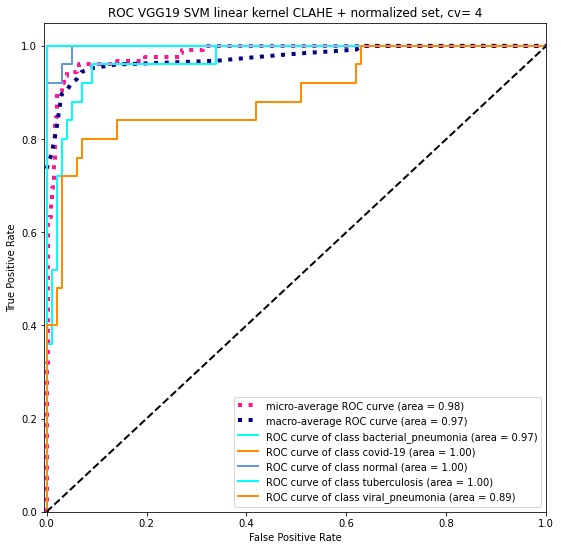

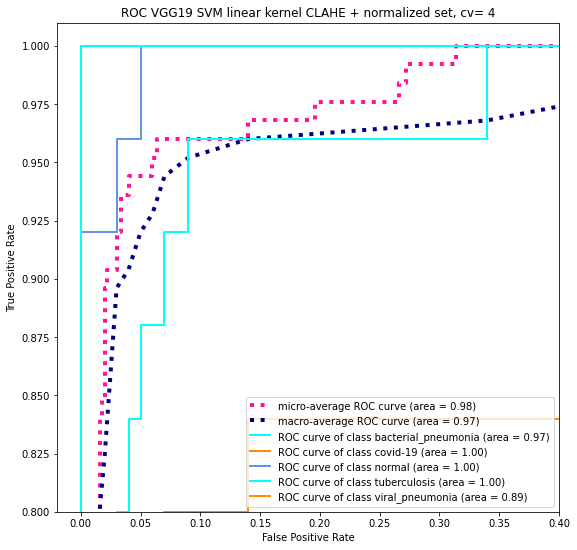

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

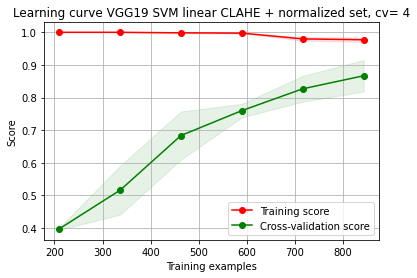

In [ ]:
cv=4
C=np.logspace(-5,1,40)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.779, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.800, total=   0.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.813, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.779, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.800, total=   0.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.813, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.779, total=   0.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.800, total=   0.7s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       1.00      1.00      1.00        25
             normal       0.83      1.00      0.91        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.86      0.72      0.78        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.90       125
       weighted avg       0.90      0.90      0.90       125

Loss: 0.22095179020300829
Confusion matrix, without norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


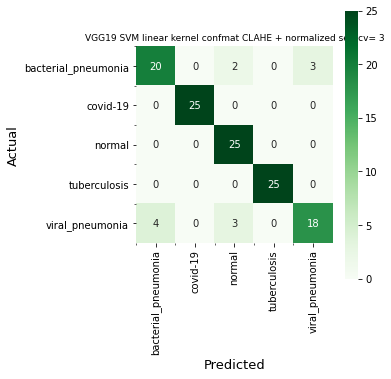

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


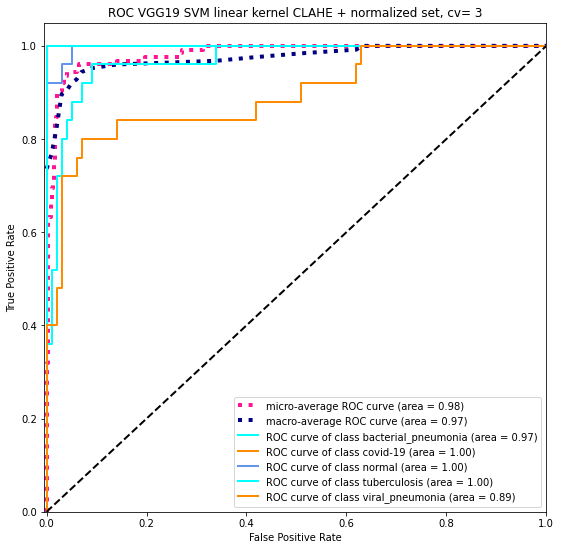

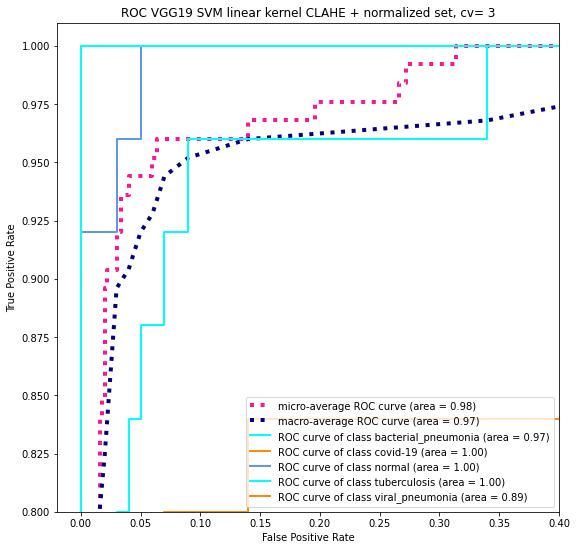

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

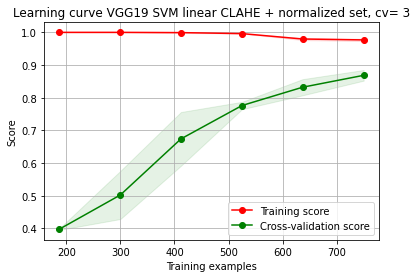

In [ ]:
cv=3
C=np.logspace(-5,1,40)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.381, total=   1.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.425, total=   0.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.416, total=   0.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.460, total=   0.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.478, total=   0.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.366, total=   0.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.312, total=   0.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.455, total=   0.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear,

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  5.6min finished


Best params:  {'C': 0.002030917620904737, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.81      1.00      0.89        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.86      0.72      0.78        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


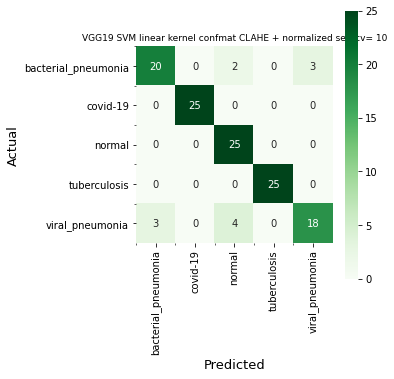

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


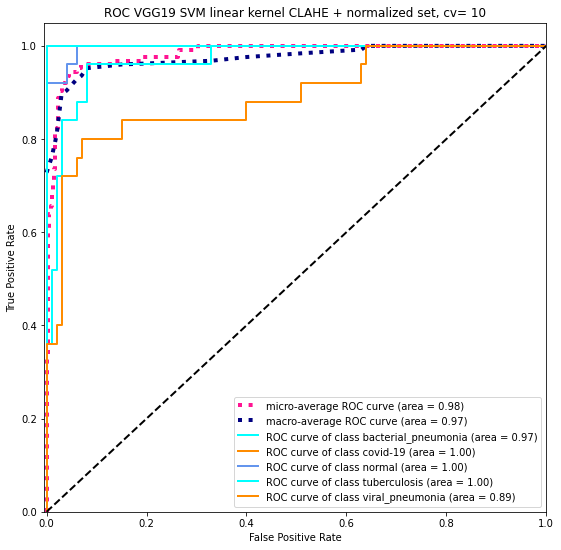

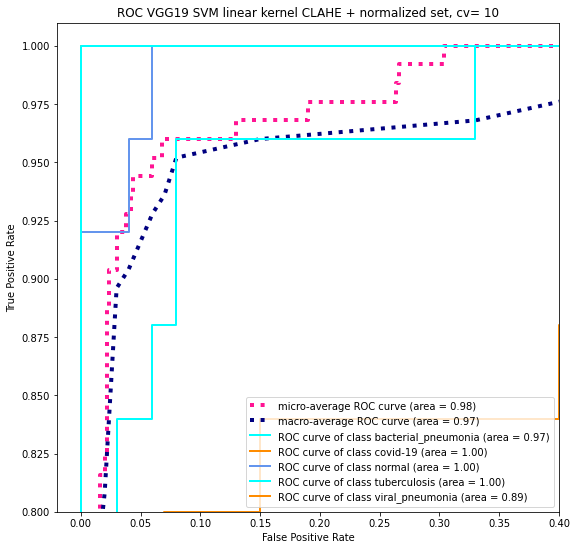

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

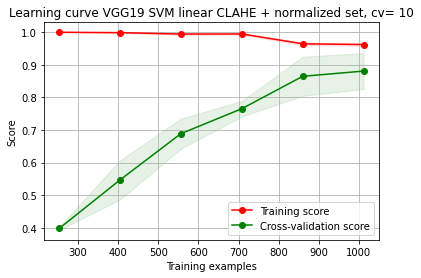

In [ ]:
cv=10
C=np.logspace(-5,1,40)
make_classification(SVC(), 'VGG19 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC VGG19 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve VGG19 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)